# Лабораторная работа № 1  
## Выполнение разведочного анализа больших данных с использованием фреймворка Apache Spark  
**Часть 2**

В данной части работы рассмотрены:

- разведочный анализ данных;
- работа с Dataframe API фреймворка Apache Spark.

Подключаем необходимые библиотеки.

In [1]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

Сформируем объект конфигурации для Apache Spark, указав необходимые параметры.
(Адаптация — локальный режим `local[*]` и указание HDFS-сервиса в docker-compose)

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создаёт и конфигурирует экземпляр SparkConf для запуска приложения Apache Spark.
    Настройки адаптированы для локального режима выполнения в Docker-контейнере 
    с использованием HDFS в качестве хранилища и поддержкой формата Iceberg.
    """
    # Имя пользователя в контейнере
    user_name = "jovyan"
    
    # Создаём объект конфигурации Spark
    conf = SparkConf()
    
    # Основные параметры приложения
    conf.setAppName("Lab1_Flight_Delay_EDA")           # Название приложения в Spark UI
    conf.setMaster("local[*]")                         # Локальный режим: используем все доступные ядра
    
    # Включаем адаптивное выполнение запросов
    conf.set("spark.sql.adaptive.enabled", "true")
    
    # Настройка ресурсов исполнителей и драйвера
    conf.set("spark.executor.memory", "6g")            # Память на один исполнитель
    conf.set("spark.executor.cores", "2")              # Количество ядер на исполнитель
    conf.set("spark.executor.instances", "1")          # Количество исполнителей
    conf.set("spark.driver.memory", "4g")              # Память драйвера
    conf.set("spark.driver.cores", "1")                # Ядра драйвера
    
    # Настройки доступа к HDFS
    conf.set("spark.hadoop.fs.defaultFS", "hdfs://hadoop-namenode:9820")
    conf.set("spark.hadoop.dfs.client.use.datanode.hostname", "true")
    
    # Подключаем необходимые пакеты и расширения для работы с Iceberg
    conf.set("spark.jars.packages", 
             "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    
    # Включаем расширения Iceberg для Spark SQL
    conf.set("spark.sql.extensions", 
             "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    
    # Настраиваем каталог Spark Catalog для хранения таблиц Iceberg
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    
    # Указываем путь к хранилищу таблиц Iceberg в HDFS
    conf.set("spark.sql.catalog.spark_catalog.warehouse", 
             f"hdfs:///user/{user_name}/warehouse")
    
    # Указываем реализацию файловой системы для Iceberg
    conf.set("spark.sql.catalog.spark_catalog.io-impl", 
             "org.apache.iceberg.hadoop.HadoopFileIO")
    
    return conf

Создаём сам объект конфигурации.

In [3]:
conf = create_spark_configuration()

Создаём и выводим на экран сессию Apache Spark

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

Укажем базу данных, которая была создана в первой части лабораторной работы.

In [5]:
database_name = "gordeev_database"

Прочитаем сохранённую в предыдущей части работы таблицу и загрузим её в Spark Dataframe.

In [6]:
df = spark.table(f"spark_catalog.{database_name}.sobd_lab1_flight_table")

Выведем прочитанную таблицу на экран.

In [7]:
df.show()

+----------+---------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+
|FlightDate|  Airline|Origin|Dest|Cancelled|Diverted|DepDelayMinutes|ArrDelayMinutes|AirTime|Distance|Year|Month|DayOfWeek|DepDel15|ArrDel15|
+----------+---------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+
|2019-04-01|Envoy Air|   LIT| ORD|    false|   false|            0.0|            0.0|   83.0|   552.0|2019|    4|        1|   false|   false|
|2019-04-02|Envoy Air|   LIT| ORD|    false|   false|            0.0|            0.0|   89.0|   552.0|2019|    4|        2|   false|   false|
|2019-04-03|Envoy Air|   LIT| ORD|    false|   false|            0.0|            0.0|   82.0|   552.0|2019|    4|        3|   false|   false|
|2019-04-04|Envoy Air|   LIT| ORD|    false|   false|          143.0|          136.0|   83.0|   552.0|2019|    4|        4|    true|    true|
|2019-

Посмотрим на схему данных.

In [8]:
df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- DepDelayMinutes: float (nullable = true)
 |-- ArrDelayMinutes: float (nullable = true)
 |-- AirTime: float (nullable = true)
 |-- Distance: float (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepDel15: boolean (nullable = true)
 |-- ArrDel15: boolean (nullable = true)



Вычислим количество строк в датафрейме.

In [9]:
df.count()

8091684

## Полные дубликаты по всем столбцам

Проверим наличие полных дубликатов (полностью идентичные строки)

In [10]:
# Группируем по всем столбцам и считаем количество одинаковых записей
duplicates = df.groupBy(df.columns).count().filter("count > 1")

# Подсчитываем общее количество групп дубликатов
duplicates_count = duplicates.count()

print(f"Общее количество групп полных дубликатов: {duplicates_count}")
duplicates.show(10)

Общее количество групп полных дубликатов: 376265
+----------+---------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+-----+
|FlightDate|  Airline|Origin|Dest|Cancelled|Diverted|DepDelayMinutes|ArrDelayMinutes|AirTime|Distance|Year|Month|DayOfWeek|DepDel15|ArrDel15|count|
+----------+---------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+-----+
|2019-04-03|Envoy Air|   LIT| DFW|    false|   false|            0.0|            0.0|   51.0|   304.0|2019|    4|        3|   false|   false|    2|
|2019-04-27|Envoy Air|   DFW| IAH|    false|   false|            0.0|            0.0|   42.0|   224.0|2019|    4|        6|   false|   false|    2|
|2019-04-10|Envoy Air|   DFW| CLL|    false|   false|            0.0|            0.0|   29.0|   164.0|2019|    4|        3|   false|   false|    2|
|2019-04-15|Envoy Air|   LIT| DFW|    false|   false|          

В датасете присутствуют полные дубликаты - строки, у которых совпадают значения во всех столбцах.

Удалим дубликаты.

In [11]:
df = df.dropDuplicates()
df.count()

7633081

In [12]:
df.show()

+----------+---------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+
|FlightDate|  Airline|Origin|Dest|Cancelled|Diverted|DepDelayMinutes|ArrDelayMinutes|AirTime|Distance|Year|Month|DayOfWeek|DepDel15|ArrDel15|
+----------+---------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+
|2019-04-23|Envoy Air|   LIT| ORD|    false|   false|            1.0|            0.0|   83.0|   552.0|2019|    4|        2|   false|   false|
|2019-04-03|Envoy Air|   ILM| LGA|    false|   false|            0.0|            0.0|   75.0|   500.0|2019|    4|        3|   false|   false|
|2019-04-06|Envoy Air|   MEM| DFW|    false|   false|           13.0|           24.0|   88.0|   431.0|2019|    4|        6|   false|    true|
|2019-04-20|Envoy Air|   MIA| PIT|    false|   false|            4.0|            0.0|  118.0|  1013.0|2019|    4|        6|   false|   false|
|2019-

## Анализ столбца `FlightDate`

`FlightDate` используется как временной признак.

Введем функцию, определяющую количество NULL-значений в столбце.

In [13]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [14]:
count_nulls(data=df, column_name="FlightDate")

Число колонок с NULL: 0 (0.00%)


Пропуски в столбце `FlightDate` отсутствуют.

Выполним проверку диапазона дат в датафрейме.

In [15]:
df.selectExpr(
    "min(FlightDate) as min_date",
    "max(FlightDate) as max_date"
).show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2019-01-01|2019-12-31|
+----------+----------+



Диапазон значений признака FlightDate составляет период с `2019-01-01` по `2019-12-31`, что соответствует заявленному периоду сбора данных.

Выполним проверку уникальности дат, чтобы понять, сколько различных дней представлено и оценить плотность временного ряда.

In [16]:
# Подсчёт общего количества записей в датафрейме
total_rows = df.count()

# Определение количества уникальных дат полётов
unique_dates = df.select("FlightDate").distinct().count()

print(f"Всего записей: {total_rows}")
print(f"Уникальных дат: {unique_dates}")
print(f"Среднее число рейсов в день: {total_rows / unique_dates:.2f}")

Всего записей: 7633081
Уникальных дат: 365
Среднее число рейсов в день: 20912.55


Построим распределение числа рейсов по датам, чтобы увидеть, равномерно ли представлены дни, а также обнаружить пики и провалы.

In [17]:
# Группируем данные по дате вылета и подсчитываем количество рейсов для каждой даты
flights_per_day = (
    df
    .groupBy("FlightDate")
    .count()
    .orderBy("FlightDate")
)

# Выводим первые 10 строк результата для предварительной проверки данных
flights_per_day.show(10)

# Преобразуем агрегированный PySpark DataFrame в pandas DataFrame
flights_per_day_pd = flights_per_day.toPandas()

# Преобразуем столбец FlightDate в тип datetime
flights_per_day_pd["FlightDate"] = pd.to_datetime(flights_per_day_pd["FlightDate"])

+----------+-----+
|FlightDate|count|
+----------+-----+
|2019-01-01|18800|
|2019-01-02|21537|
|2019-01-03|20392|
|2019-01-04|20344|
|2019-01-05|17646|
|2019-01-06|20209|
|2019-01-07|20600|
|2019-01-08|19037|
|2019-01-09|19412|
|2019-01-10|20285|
+----------+-----+
only showing top 10 rows



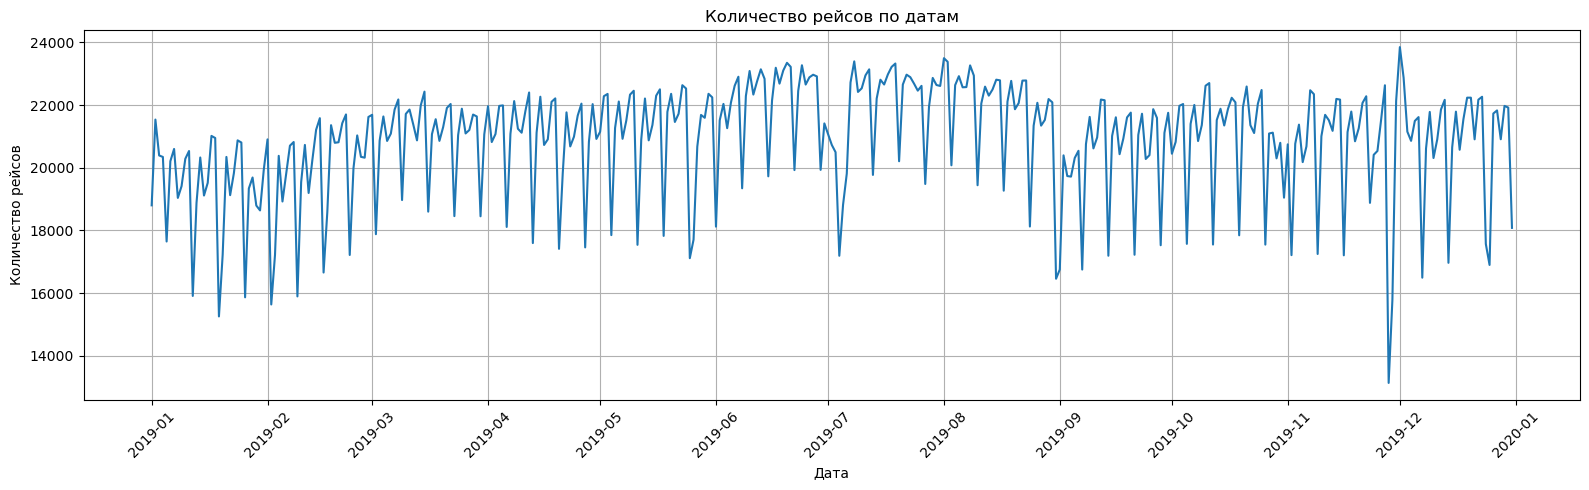

In [18]:
# Создание фигуры для построения графика временного ряда
plt.figure(figsize=(16, 5))

# Построение линейного графика количества рейсов по датам
# flights_per_day_pd["FlightDate"] — ось X (даты)
# flights_per_day_pd["count"] — ось Y (количество рейсов в день)
plt.plot(
    flights_per_day_pd["FlightDate"],
    flights_per_day_pd["count"]
)

# Установка заголовка и подписей осей
plt.title("Количество рейсов по датам")
plt.xlabel("Дата")
plt.ylabel("Количество рейсов")

# Форматирование оси X — отображаем каждый месяц для лучшей читаемости
# MonthLocator(interval=1) — метки для каждого месяца
# DateFormatter('%Y-%m') — формат отображения года и месяца
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Поворот подписей оси X на 45° для предотвращения наложения
plt.xticks(rotation=45)

# Добавление сетки для удобства чтения значений
plt.grid(True)

# Автоматическая оптимизация расположения элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

Из графика видно, что количество рейсов по датам в течение года распределено неравномерно.
Наблюдается выраженная периодичность, связанная с днями недели: регулярные локальные минимумы
соответствуют выходным дням, когда интенсивность авиаперевозок ниже.

В течение года также прослеживаются сезонные колебания: рост числа рейсов в весенне-летний период
и некоторое снижение в начале года и осенью. Отдельные резкие провалы могут быть связаны
с праздничными днями или погодными условиями.

## Анализ столбца `Airline`

`Airline` — категориальный признак, обозначающий авиакомпанию-перевозчика.

Проверим, есть ли пропуски в столбце `Airline`

In [19]:
count_nulls(data=df, column_name="Airline")

Число колонок с NULL: 0 (0.00%)


Пропусков в столбце нет.

Определим, сколько уникальных авиакомпаний в датафрейме

In [20]:
unique_airlines = df.select("Airline").distinct().count()
print(f"Уникальных авиакомпаний: {unique_airlines}")

Уникальных авиакомпаний: 26


Посмотрим на число рейсов по авиакомпаниям: отсортируем перевозчиков по объёму рейсов и определим их долю в общем количестве.

In [21]:
from pyspark.sql import functions as F

# Общее число записей (для вычисления долей)
total_rows = df.count()

# Группировка по авиакомпаниям и подсчёт количества рейсов для каждой
airline_counts = (
    df.groupBy("Airline")                          # Группировка по названию авиакомпании
      .agg(F.count("*").alias("num_flights"))      # Подсчёт всех записей в группе
      .orderBy(F.desc("num_flights"))              # Сортировка по убыванию числа рейсов
)

# Добавление колонки с процентной долей каждой авиакомпании в общем объёме рейсов
airline_counts_pct = airline_counts.withColumn(
    "pct", F.round(F.col("num_flights") / F.lit(total_rows) * 100, 3)
).toPandas()

# Вывод топ-30 авиакомпаний по числу рейсов и их доли в процентах
airline_counts_pct.head(30)

,Airline,num_flights,pct
0,Southwest Airlines Co.,1282750,16.805
1,Delta Air Lines Inc.,900230,11.794
2,American Airlines Inc.,889151,11.649
3,SkyWest Airlines Inc.,799576,10.475
4,United Air Lines Inc.,594624,7.790
5,Republic Airlines,315140,4.129
6,Envoy Air,309678,4.057
7,JetBlue Airways,286221,3.750
8,Comair Inc.,275082,3.604
9,Alaska Airlines Inc.,252120,3.303


В таблице отображаются авиакомпании-лидеры по объёму перевозок за 2019 год. В топе компании Southwest Airlines Co. (16.8%), Delta Air Lines Inc. (11.8%), American Airlines Inc. (11.6%).	

Построим столбчатую диаграмму топ-10 авиакомпаний по числу рейсов, чтобы визуально оценить распределение активности перевозчиков

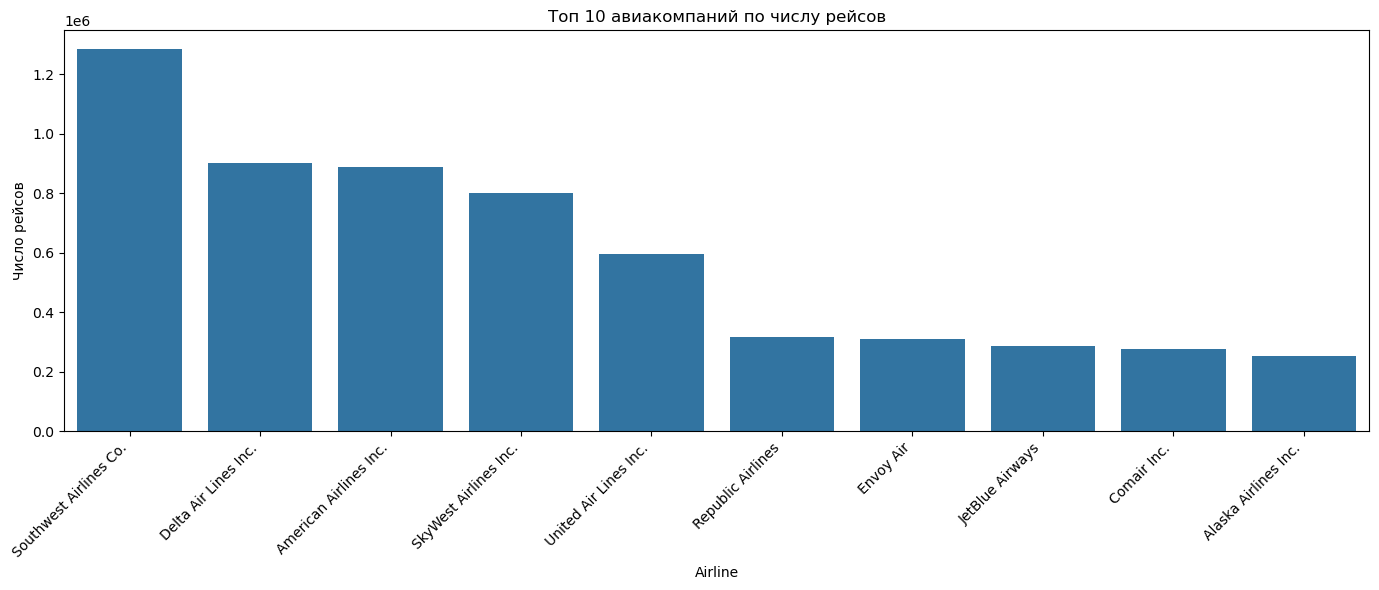

In [22]:
# Выбираем количество авиакомпаний для отображения на графике (топ-10)
top_n = 10

# Отбираем топ-N авиакомпаний из подготовленного pandas DataFrame
top_airlines_pd = airline_counts_pct.head(top_n)

# Создание фигуры для столбчатой диаграммы
plt.figure(figsize=(14,6))

# Построение столбчатой диаграммы с помощью seaborn
sns.barplot(
    data=top_airlines_pd, 
    x="Airline", 
    y="num_flights", 
    order=top_airlines_pd["Airline"]
)

# Поворот подписей оси X на 45° вправо для предотвращения наложения длинных названий
plt.xticks(rotation=45, ha="right")

# Установка заголовка и подписей осей
plt.title(f"Топ {top_n} авиакомпаний по числу рейсов")
plt.xlabel("Airline")
plt.ylabel("Число рейсов")

# Автоматическая оптимизация расположения элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

## Анализ столбцов Origin и Dest

Origin и Dest — категориальные признаки, обозначающие аэропорты вылета и назначения соответственно.

Проверим, есть ли пропуски в столбцв `Origin` и `Dest`

In [23]:
count_nulls(data=df, column_name="Origin")

Число колонок с NULL: 0 (0.00%)


In [24]:
count_nulls(data=df, column_name="Dest")

Число колонок с NULL: 0 (0.00%)


Пропусков в столбцах нет.

Проверим формат IATA-кодов. IATA-код должен состоять ровно из трёх заглавных латинских букв (A-Z)

In [25]:
# Определение регулярного выражения для проверки формата IATA-кода аэропорта
iata_pattern = r"^[A-Z]{3}$"

# Подсчёт количества строк, в которых код аэропорта вылета (Origin) 
# не соответствует стандарту IATA (длина ≠ 3 или содержит недопустимые символы)
invalid_origin = df.filter(~col("Origin").rlike(iata_pattern)).count()

# Аналогичный подсчёт для кодов аэропортов назначения (Dest)
invalid_dest = df.filter(~col("Dest").rlike(iata_pattern)).count()

# Вывод результатов
print(f"Некорректных Origin: {invalid_origin}")
print(f"Некорректных Dest: {invalid_dest}")

Некорректных Origin: 0
Некорректных Dest: 0


Все значения соответствуют формату IATA-кодов аэропортов.

Найдем количество уникальных аэропортов

In [26]:
unique_origin = df.select("Origin").distinct().count()
unique_dest = df.select("Dest").distinct().count()

print(f"Уникальных Origin: {unique_origin}")
print(f"Уникальных Dest:   {unique_dest}")

Уникальных Origin: 373
Уникальных Dest:   373


Количество уникальных аэропортов вылета и назначения одинаково, что говорит о целостности маршрутной сети и отсутствии перекосов, связанных с неполнотой данных.

Исследуем, как распределяются рейсы между аэропортами вылета. Это позволяет выявить ключевые транспортные узлы (хабы) и оценить концентрацию трафика.

In [27]:
# Группируем данные по аэропорту вылета (Origin)
# и считаем количество рейсов для каждого аэропорта
origin_distribution = (
    df
    .groupBy("Origin")
    .count()
    .orderBy(col("count").desc()) # сортировка по убыванию числа рейсов
)

origin_distribution.show(10)


+------+------+
|Origin| count|
+------+------+
|   ORD|381523|
|   ATL|356023|
|   DFW|287156|
|   DEN|276888|
|   CLT|241196|
|   LAX|232214|
|   SEA|181218|
|   IAH|172058|
|   PHX|169861|
|   DTW|167804|
+------+------+
only showing top 10 rows



In [28]:
# Общее количество рейсов в датасете
total_flights = df.count()

# Добавляем долю рейсов каждого аэропорта от общего числа
# и отбираем топ-20 аэропортов для более компактного анализа
origin_distribution_pd = (
    origin_distribution
    .withColumn("share", col("count") / total_flights)
    .limit(20)
    .toPandas()  # перевод в Pandas для удобного просмотра и визуализации
)

origin_distribution_pd

,Origin,count,share
0,ORD,381523,0.049983
1,ATL,356023,0.046642
2,DFW,287156,0.037620
3,DEN,276888,0.036275
4,CLT,241196,0.031599
5,LAX,232214,0.030422
6,SEA,181218,0.023741
7,IAH,172058,0.022541
8,PHX,169861,0.022253
9,DTW,167804,0.021984


Полученные результаты показывают выраженную концентрацию рейсов в ограниченном числе аэропортов.
Так, крупнейшие узлы (ORD, ATL, DFW, DEN) обслуживают от 3 до 5% всех рейсов каждый

Распределение носит характер длинного хвоста:
небольшое число аэропортов выполняет значительную долю рейсов, в то время как большинство аэропортов имеет существенно меньшую загрузку.

Сравним роли аэропортов с точки зрения пунктов вылета и пунктов назначения.
Для этого отдельно посчитаем:
- количество рейсов, вылетающих из аэропорта (out_degree);
- количество рейсов, прибывающих в аэропорт (in_degree)

In [29]:
# Подсчет количества рейсов, вылетающих из каждого аэропорта
# Origin — аэропорт вылета
origin_counts = (
    df
    .groupBy("Origin")                        # Группировка по коду аэропорта вылета
    .count()
    .withColumnRenamed("Origin", "Airport")   # приводим к общему имени столбца
    .withColumnRenamed("count", "out_degree") # число исходящих рейсов
)

# Подсчет количества рейсов, прибывающих в каждый аэропорт
# Dest — аэропорт назначения
dest_counts = (
    df
    .groupBy("Dest")                          # Группировка по коду аэропорта прибытия
    .count()
    .withColumnRenamed("Dest", "Airport")     # то же имя столбца для join
    .withColumnRenamed("count", "in_degree")  # число входящих рейсов
)

На следующем шаге объединим полученные таблицы и рассчитаем баланс аэропорта — разницу между количеством вылетов и прилётов.

In [30]:
# Объединяем данные по аэропортам
# Используем outer join, чтобы не потерять аэропорты,
# которые встречаются только как Origin или только как Dest
airport_balance = (
    origin_counts
    .join(dest_counts, on="Airport", how="outer")
    .fillna(0)  # отсутствующие значения заменяем на 0
    .withColumn(
        "balance",
        col("out_degree") - col("in_degree")  # баланс: вылеты - прилеты
    )
)


Посмотрим на аэропорты с наибольшим положительным балансом —
то есть те, где вылетов больше, чем прилётов.

In [31]:
airport_balance.orderBy(col("balance").desc()).show(10)

+-------+----------+---------+-------+
|Airport|out_degree|in_degree|balance|
+-------+----------+---------+-------+
|    ATL|    356023|   351763|   4260|
|    DFW|    287156|   285566|   1590|
|    OAK|     50094|    48689|   1405|
|    SJC|     64025|    62952|   1073|
|    MDW|     80037|    79075|    962|
|    OGG|     22862|    22021|    841|
|    BWI|    100241|    99442|    799|
|    BNA|     79774|    79159|    615|
|    RDU|     67146|    66611|    535|
|    CLE|     50080|    49555|    525|
+-------+----------+---------+-------+
only showing top 10 rows



Теперь рассмотрим противоположную ситуацию — аэропорты, где прилётов больше, чем вылетов.

In [32]:
airport_balance.orderBy(col("balance")).show(10)

+-------+----------+---------+-------+
|Airport|out_degree|in_degree|balance|
+-------+----------+---------+-------+
|    SEA|    181218|   184125|  -2907|
|    IAH|    172058|   173804|  -1746|
|    DCA|    134346|   135939|  -1593|
|    LAX|    232214|   233767|  -1553|
|    PHL|    149013|   150433|  -1420|
|    LGA|    160137|   161509|  -1372|
|    HNL|     43212|    44377|  -1165|
|    JFK|    122100|   123025|   -925|
|    SLC|    115544|   116401|   -857|
|    MSP|    153262|   154116|   -854|
+-------+----------+---------+-------+
only showing top 10 rows



Рассмотрим баланс для самых крупных  аэропортов

В качестве меры размера аэропорта будем использовать общий пассажиропоток в рейсах:
total_traffic=out_degree+in_degree

In [33]:
# Добавляем показатель общего трафика аэропорта
airport_balance_with_traffic = (
    airport_balance
    .withColumn(
        "total_traffic",  # Имя нового столбца
        col("out_degree") + col("in_degree") # Суммирование исходящего и входящего потоков
    )
)


In [34]:
# Получение топ-10 аэропортов по общему объёму трафика
# Сортировка выполняется по убыванию значения total_traffic (сумма вылетов и прилётов)
top_airports = (
    airport_balance_with_traffic
    .orderBy(col("total_traffic").desc())
    .select(
        "Airport",
        "out_degree",
        "in_degree",
        "balance",
        "total_traffic"
    )
)

top_airports.show(10)

+-------+----------+---------+-------+-------------+
|Airport|out_degree|in_degree|balance|total_traffic|
+-------+----------+---------+-------+-------------+
|    ORD|    381523|   381344|    179|       762867|
|    ATL|    356023|   351763|   4260|       707786|
|    DFW|    287156|   285566|   1590|       572722|
|    DEN|    276888|   276893|     -5|       553781|
|    CLT|    241196|   241799|   -603|       482995|
|    LAX|    232214|   233767|  -1553|       465981|
|    SEA|    181218|   184125|  -2907|       365343|
|    IAH|    172058|   173804|  -1746|       345862|
|    PHX|    169861|   169948|    -87|       339809|
|    DTW|    167804|   167759|     45|       335563|
+-------+----------+---------+-------+-------------+
only showing top 10 rows



Ниже визуализируем дисбаланс между вылетами и прилётами для крупнейших аэропортов (по суммарному трафику). Определим абсолютный баланс потока и посмотрим, есть ли крупные аэропорты с заметной асимметрией потоков.

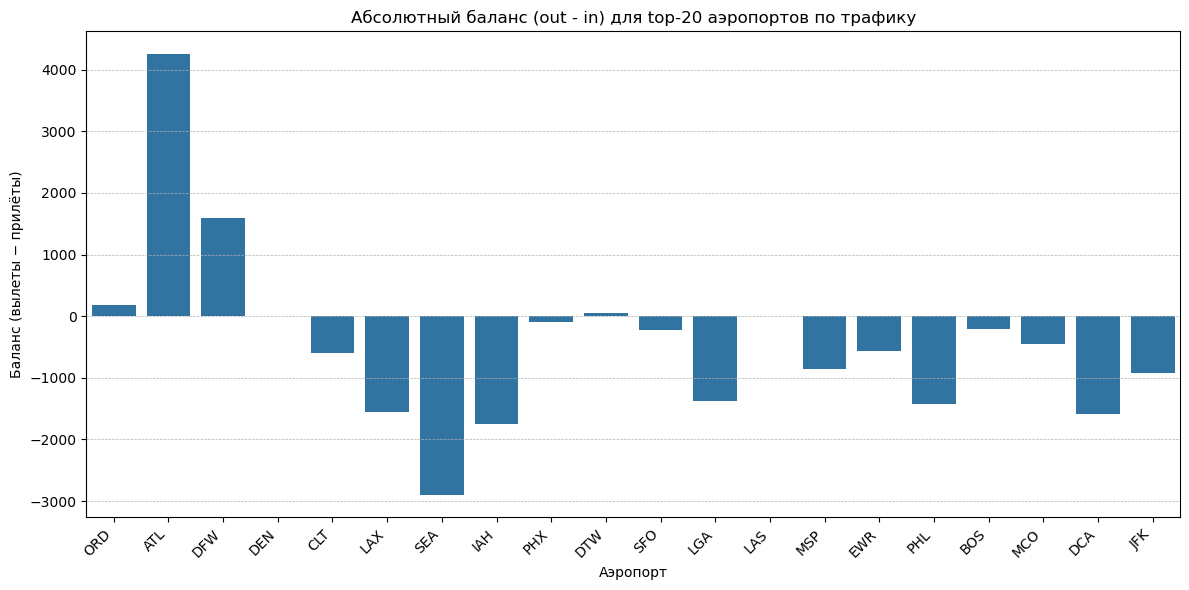

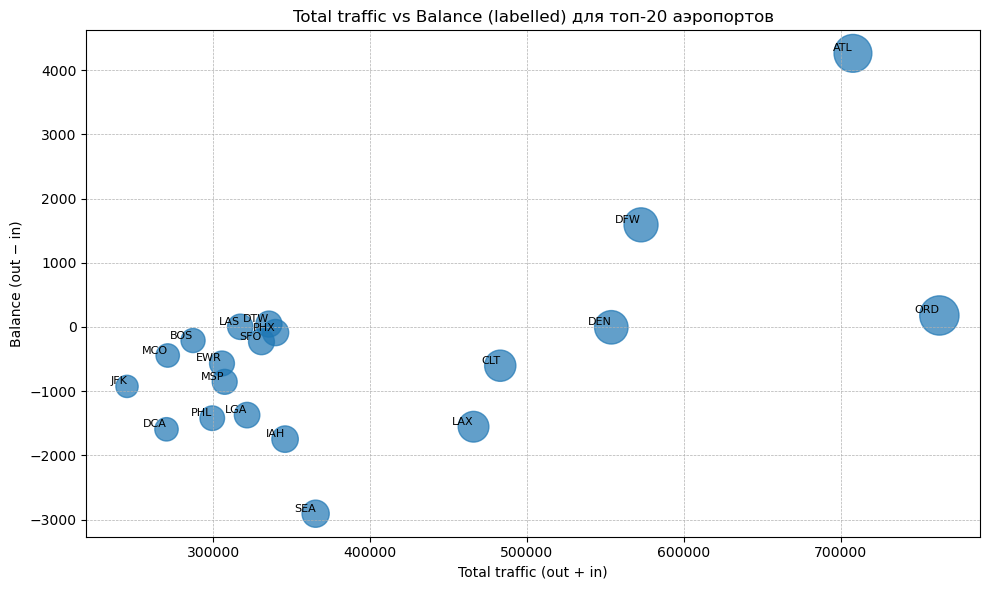

In [35]:
# Подготовим DataFrame для визуализаций: возьмём топ-20 аэропортов по total_traffic
top_n = 20
top_airports_pd = (
    airport_balance_with_traffic
    .orderBy(col("total_traffic").desc())
    .limit(top_n)
    .select("Airport", "out_degree", "in_degree", "balance", "total_traffic")
    .toPandas()
)

# Добавим колонку относительного баланса в процентах
top_airports_pd["relative_balance_pct"] = 100.0 * top_airports_pd["balance"] / top_airports_pd["total_traffic"]

# Сортировка для аккуратного отображения (по total_traffic)
top_airports_pd = top_airports_pd.sort_values("total_traffic", ascending=False).reset_index(drop=True)

# 1) График 1: столбчатая диаграмма абсолютного баланса (вылеты − прилёты)
plt.figure(figsize=(12,6))
sns.barplot(data=top_airports_pd, x="Airport", y="balance")
plt.title(f"Абсолютный баланс (out - in) для top-{top_n} аэропортов по трафику")
plt.xlabel("Аэропорт")
plt.ylabel("Баланс (вылеты − прилёты)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# 2) График 2: диаграмма рассеяния — зависимость баланса от общего трафика
# Размер точек пропорционален объёму трафика — крупные точки соответствуют крупнейшим хабам
plt.figure(figsize=(10,6))
# масштабируем размер точки по total_traffic (делим на константу, чтобы точки не были слишком большими)
sizes = (top_airports_pd["total_traffic"] / top_airports_pd["total_traffic"].max()) * 800
plt.scatter(top_airports_pd["total_traffic"], top_airports_pd["balance"], s=sizes, alpha=0.7)
for i, row in top_airports_pd.iterrows():
    plt.text(row["total_traffic"], row["balance"], row["Airport"], fontsize=8, va='bottom', ha='right')
plt.title("Total traffic vs Balance (labelled) для топ-20 аэропортов")
plt.xlabel("Total traffic (out + in)")
plt.ylabel("Balance (out − in)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


Абсолютный баланс показывает, в каких аэропортах число вылетов превышает число прилётов и наоборот.

- Для большинства аэропортов баланс по модулю **значительно меньше общего объёма трафика**
- Аэропорты ORD, DEN, PHX, DTW и др. демонстрируют **почти нулевой баланс**
- Отдельные аэропорты, такие как **ATL** и **DFW**, имеют положительный баланс, что может отражать их роль как крупных распределительных узлов, где часть рейсов «перетекает» дальше по сети.
- Аэропорты с отрицательным балансом (например, **SEA**, **LAX**, **IAH**) принимают больше рейсов, чем отправляют, однако величина этого дисбаланса остаётся умеренной относительно их масштаба.


Определим самые популярные авиа-маршруты и представим результаты в виде тепловой кары

In [36]:
# Выберем топ-15 аэропортов по общему трафику
top_airports_list = (
    airport_balance_with_traffic
    .orderBy(col("total_traffic").desc())
    .limit(15)
    .select("Airport")
    .toPandas()["Airport"]
    .tolist()
)

# Фильтруем маршруты только между этими аэропортами
filtered_routes = (
    df
    .filter(col("Origin").isin(top_airports_list))
    .filter(col("Dest").isin(top_airports_list))
    .groupBy("Origin", "Dest")
    .count()
)

# Преобразуем в pandas-матрицу
heatmap_pd = (
    filtered_routes
    .toPandas()
    .pivot(index="Origin", columns="Dest", values="count")
    .fillna(0)
)


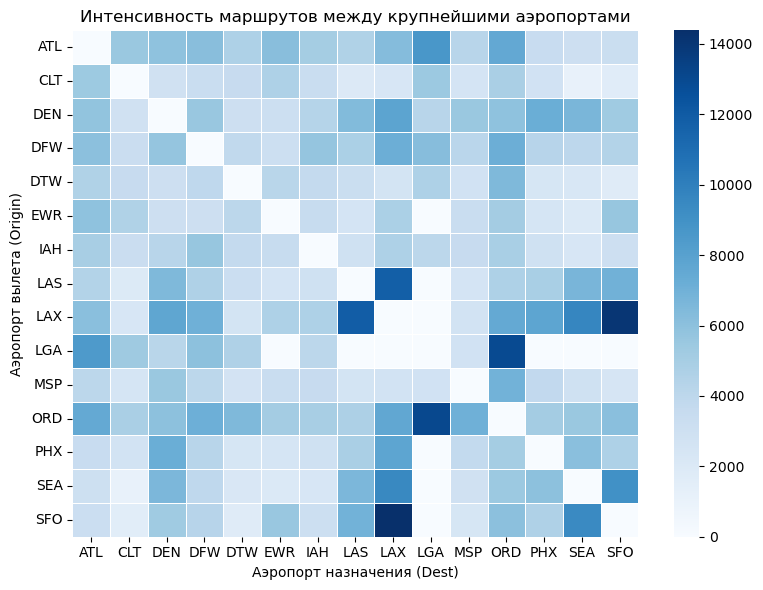

In [37]:
# Создание фигуры
plt.figure(figsize=(8, 6))

# Построение тепловой карты с помощью seaborn
# cmap="Blues" — градиент от светлого к тёмному синему для отображения интенсивности
# linewidths=0.5 — тонкие линии между ячейками для лучшей читаемости
sns.heatmap(
    heatmap_pd,
    cmap="Blues",
    linewidths=0.5
)

plt.title("Интенсивность маршрутов между крупнейшими аэропортами")
plt.xlabel("Аэропорт назначения (Dest)")
plt.ylabel("Аэропорт вылета (Origin)")

# Автоматическая оптимизация расположения элементов графика
plt.tight_layout()

plt.show()

Наиболее загруженные маршруты (тёмно-синие ячейки >10–14 тыс. рейсов) сосредоточены вокруг хабов ATL (Atlanta), ORD (Chicago), DFW (Dallas), DEN (Denver) и LAX (Los Angeles). Самые популярные направления: LAS-LAX, LAX-LAS, LSX-SFO, LGA-ORD, SFO–LAX. Заметна сильная асимметрия: многие аэропорты имеют ярко выраженные «доминирующие» хабы. Низкая интенсивность (светлые/белые ячейки) наблюдается на маршрутах между менее связанными узлам.

## Анализ бинарных признаков

Бинарные признаки отражают факт наступления событий:
- Cancelled — рейс отменён;
- Diverted — рейс перенаправлен;
- DepDel15 — задержка вылета ≥ 15 минут;
- ArrDel15 — задержка прибытия ≥ 15 минут.
Для этих признаков важно: проверить наличие пропусков; оценить баланс классов; визуально сравнить доли событий.

Проверим, есть ли пропуски в этих столбцах

In [38]:
count_nulls(data=df, column_name="Cancelled")
count_nulls(data=df, column_name="Diverted")
count_nulls(data=df, column_name="DepDel15")
count_nulls(data=df, column_name="ArrDel15")

Число колонок с NULL: 0 (0.00%)
Число колонок с NULL: 0 (0.00%)
Число колонок с NULL: 116689 (1.53%)
Число колонок с NULL: 142970 (1.87%)


Признаки Cancelled и Diverted не содержат пропусков, но в DepDel15 и ArrDel15 присутствует небольшая доля NULL (≈1.5–1.9%).

Так как флаги задержек (`DepDel15`, `ArrDel15`) логически определяются величиной задержки в минутах (`DepDelayMinutes`, `ArrDelayMinutes`), пропуски можно восстановить на основе числовых столбцов. 
Проверим, существуют ли значения задержки вылета в минутах (``DepDelayMinutes) и задержки прибытия в минутах (`ArrDelayMinutes`) для записей, в которых соответствующих флагов нет

In [39]:
# Проверяем, существуют ли рейсы,
# у которых флаг DepDel15 отсутствует,
# но при этом указано числовое значение DepDelayMinutes
dep_inconsistent = (
    df
    .filter(
        col("DepDel15").isNull() &
        col("DepDelayMinutes").isNotNull()
    )
    .count()
)

print(f"Рейсов с NULL DepDel15 и заполненным DepDelayMinutes: {dep_inconsistent}")


Рейсов с NULL DepDel15 и заполненным DepDelayMinutes: 0


In [40]:
# Аналогичная проверка для прибытия
arr_inconsistent = (
    df
    .filter(
        col("ArrDel15").isNull() &
        col("ArrDelayMinutes").isNotNull()
    )
    .count()
)

print(f"Рейсов с NULL ArrDel15 и заполненным ArrDelayMinutes: {arr_inconsistent}")


Рейсов с NULL ArrDel15 и заполненным ArrDelayMinutes: 0


Ввиду того, что для рейсов, не имеющих флагов DepDel15 и ArrDel15, нет информации о задержках в минутах, оставим пропущенные значения этих флагов NULL.

Далее оценим баланс классов: долю значений True, False и NULL для каждого бинарного признака. Это позволяет количественно оценить редкость событий (например, отмен или перенаправлений).

In [41]:
from pyspark.sql.functions import col

def binary_distribution(df, column):
    """Вычисляет распределение бинарного признака в Spark DataFrame.

    Функция подсчитывает количество значений True, False и NULL для указанного столбца,
    а также их процентные доли от общего числа записей.

    Args:
        df (pyspark.sql.DataFrame): Входной датафрейм Spark.
        column (str): Имя бинарного столбца для анализа.

    Returns:
        dict: Словарь со следующими ключами:
            - 'feature': имя анализируемого столбца
            - 'true': количество записей со значением True
            - 'false': количество записей со значением False
            - 'null': количество записей со значением NULL
            - 'true_pct': доля True в процентах
            - 'false_pct': доля False в процентах
            - 'null_pct': доля NULL в процентах
    """
    # Подсчёт общего количества строк
    total = df.count()

    # Подсчёт абсолютных значений по трём категориям
    true_count = df.filter(col(column) == True).count()
    false_count = df.filter(col(column) == False).count()
    null_count = df.filter(col(column).isNull()).count()

    # Формируем и возвращаем словарь с абсолютными и относительными показателями
    return {
        "feature": column,
        "true": true_count,
        "false": false_count,
        "null": null_count,
        "true_pct": true_count / total if total > 0 else 0.0,
        "false_pct": false_count / total if total > 0 else 0.0,
        "null_pct": null_count / total if total > 0 else 0.0,
    }


# Список бинарных признаков, подлежащих анализу
cols = ["Cancelled", "Diverted", "DepDel15", "ArrDel15"]

# Применяем функцию ко всем указанным столбцам и собираем результаты в список словарей
stats = [binary_distribution(df, c) for c in cols]

# Преобразуем список словарей в pandas DataFrame для удобного табличного представления
import pandas as pd
stats_df = pd.DataFrame(stats)

# Выводим итоговую таблицу распределения бинарных признаков
stats_df

,feature,true,false,null,true_pct,false_pct,null_pct
0,Cancelled,122388,7510693,0,0.016034,0.983966,0.000000
1,Diverted,20582,7612499,0,0.002696,0.997304,0.000000
2,DepDel15,1487610,6028782,116689,0.194890,0.789823,0.015287
3,ArrDel15,1527385,5962726,142970,0.200101,0.781169,0.018730


Отмены (Cancelled) и перенаправления (Diverted) являются редкими событиями (≈1.6% и ≈0.27%).
Задержки ≥15 минут встречаются значительно чаще:
- вылет — ≈19.5%;
- прибытие — ≈20%;
Доля неопределённых значений по задержкам не превышает 2%.

Для наглядного сравнения долей событий визуализируем распределение `True / False / Unknown` для каждого бинарного признака.

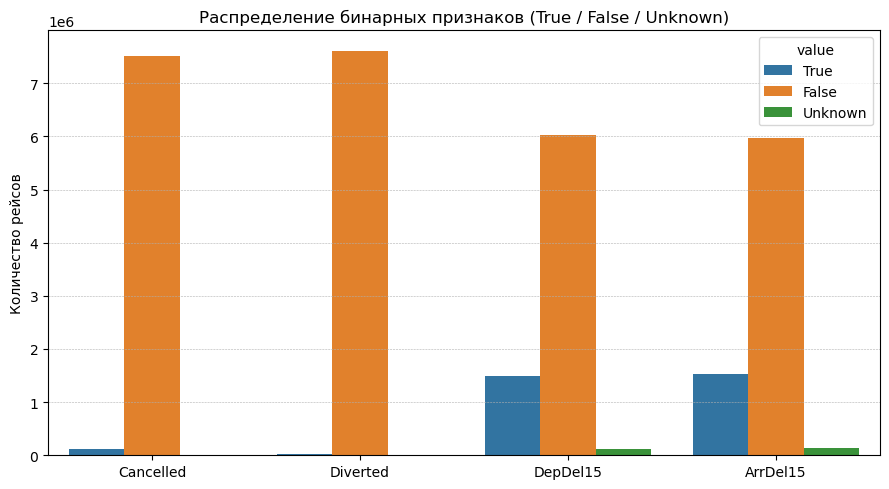

In [42]:
# Подготавливаем данные в "длинном" (long) формате для построения столбчатой диаграммы
# Это необходимо, чтобы seaborn мог корректно отобразить три категории (True / False / Unknown) 
# для каждого бинарного признака в виде сгруппированных столбцов
viz_rows = []

# Проходим по каждой строке таблицы статистики и создаём три записи для каждой категории
for _, row in stats_df.iterrows():
    viz_rows.extend([
        {"feature": row["feature"], "value": "True", "count": row["true"]},
        {"feature": row["feature"], "value": "False", "count": row["false"]},
        {"feature": row["feature"], "value": "Unknown", "count": row["null"]},
    ])

# Преобразуем список словарей в pandas DataFrame в "длинном" формате
viz_df = pd.DataFrame(viz_rows)

plt.figure(figsize=(9,5))

# Строим сгруппированную столбчатую диаграмм
sns.barplot(data=viz_df, x="feature", y="count", hue="value")
plt.title("Распределение бинарных признаков (True / False / Unknown)")
plt.ylabel("Количество рейсов")
plt.xlabel("")

# Добавляем сетку по оси Y для удобства чтения значений
plt.grid(axis="y", linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()

Для всех признаков доминирует значение False, что отражает нормальный режим выполнения рейсов.
Отмены и перенаправления визуально подтверждаются как редкие события.
Задержки ≥15 минут являются массовым явлением по сравнению с отменами.
Доля Unknown заметна только у признаков задержек и остаётся незначительной.

На следующем шаге проанализируем, меняется ли доля задержек в течение года, агрегируя данные по месяцам.

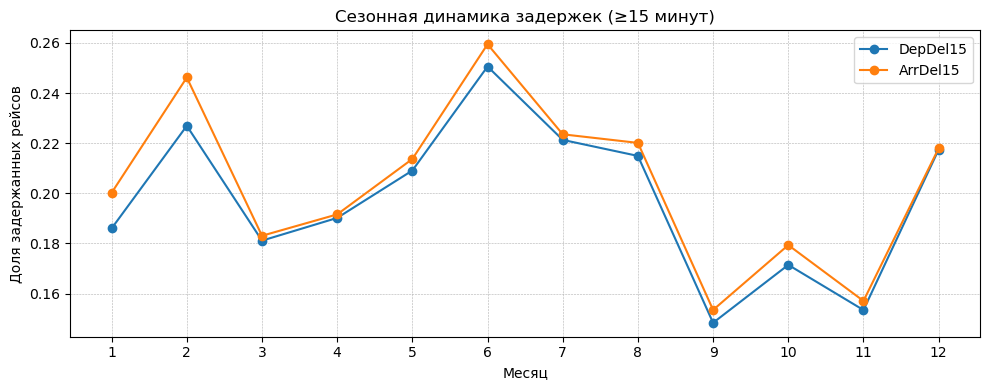

In [43]:
# Расчёт доли задержек вылета (DepDel15) по месяцам
# 1. Исключаем строки с NULL в DepDel15
# 2. Группируем по номеру месяца
# 3. Вычисляем долю True (задержки ≥15 мин) как сумму бинарного столбца / общее количество
# 4. Преобразуем в pandas для построения графика
dep_month = (
    df.filter(col("DepDel15").isNotNull())                  # Убираем неопределённые значения
      .groupBy("Month")                                     # Группировка по номеру месяца
      .agg(                                                 # Агрегация: доля задержек
          (sum(col("DepDel15").cast("int")) / count("*"))
          .alias("dep_delay_rate")
      )
      .orderBy("Month")                                     # Сортировка по месяцам для хронологического порядка
      .toPandas()                                           # Преобразование в pandas для matplotlib
)

# Аналогичный расчёт доли задержек прибытия (ArrDel15) по месяцам
arr_month = (
    df.filter(col("ArrDel15").isNotNull())
      .groupBy("Month")
      .agg(
          (sum(col("ArrDel15").cast("int")) / count("*"))
          .alias("arr_delay_rate")
      )
      .orderBy("Month")
      .toPandas()
)

# Построение линейного графика сезонной динамики задержек
plt.figure(figsize=(10,4))    # Размер графика для хорошей читаемости

# Линия для задержек вылета
plt.plot(
    dep_month["Month"], 
    dep_month["dep_delay_rate"], 
    marker='o',         # Маркер 'o' для выделения месячных значений
    label="DepDel15"
)

# Линия для задержек прибытия
plt.plot(
    arr_month["Month"], 
    arr_month["arr_delay_rate"], 
    marker='o',
    label="ArrDel15"
)

# Подписи осей и заголовок
plt.xlabel("Месяц")
plt.ylabel("Доля задержанных рейсов")
plt.title("Сезонная динамика задержек (≥15 минут)")

# Устанавливаем метки оси X от 1 до 12 (январь–декабрь)
plt.xticks(range(1, 13))

# Добавляем сетку по оси Y для удобства чтения значений
plt.grid(True, linestyle="--", linewidth=0.4)

# Добавляем легенду для различения линий
plt.legend()

# Оптимизируем расположение элементов графика
plt.tight_layout()

# Отображаем график
plt.show()

Из полученного графика видим, что наблюдается выраженная сезонность задержек. Пики приходятся на летние месяцы, что может быть связано с ростом пассажиропотока и перегруженностью аэропортов.
Задержки прибытия всегда сопровождаются задержками вылета, но имеют немного более высокий уровень.

## Анализ признаков DepDelayMinutes и ArrDelayMinutes

DepDelayMinutes и ArrDelayMinutes — количественные признаки, отражающие минуты задержки вылета и прилёта соответственно.

Проверим, есть ли пропуски в этих столбцах

In [44]:
# Проверка пропусков и общего числа записей в колонках задержек
total = df.count()
dep_nulls = df.filter(col("DepDelayMinutes").isNull()).count()
arr_nulls = df.filter(col("ArrDelayMinutes").isNull()).count()

print(f"Всего записей: {total}")
print(f"DepDelayMinutes NULL: {dep_nulls} ({dep_nulls/total:.4%})")
print(f"ArrDelayMinutes  NULL: {arr_nulls} ({arr_nulls/total:.4%})")

# Для безопасных агрегатов будем работать с non-null подмножествами
df_dep = df.filter(col("DepDelayMinutes").isNotNull())
df_arr = df.filter(col("ArrDelayMinutes").isNotNull())


Всего записей: 7633081
DepDelayMinutes NULL: 116689 (1.5287%)
ArrDelayMinutes  NULL: 142970 (1.8730%)


Пропуски связаны преимущественно с отменёнными или перенаправленными рейсами. Заполним их нулями — логичное решение для задержки не состоявшегося рейса.

Пропуски связаны в основном с отменёнными или перенаправленными рейсами. Решено не заполнять их искусственно — оставляем как есть, чтобы не искажать природу данных.

Определим ключевые статистики по обоим признакам

In [45]:
# Статистическое резюме по столбцам — использую Spark summary + дополнительно квантили для точности
stats = df.select("DepDelayMinutes", "ArrDelayMinutes").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max")
stats.show(truncate=False)

+-------+-----------------+------------------+
|summary|DepDelayMinutes  |ArrDelayMinutes   |
+-------+-----------------+------------------+
|count  |7516392          |7490111           |
|mean   |15.10272202407751|15.240317800363707|
|stddev |49.90212870711141|49.65219442474328 |
|min    |0.0              |0.0               |
|25%    |0.0              |0.0               |
|50%    |0.0              |0.0               |
|75%    |8.0              |9.0               |
|max    |2976.0           |2973.0            |
+-------+-----------------+------------------+



Медиана и первый квартиль равны 0 — более половины рейсов вылетают и прилетают без задержки. Средние значения задержек `~`15 минут, но стандартное отклонение очень высокое (`~`50 мин), что указывает на сильную скошенность вправо и наличие экстремальных задержек (до `~`3000 минут). Третий квартиль составляет всего 8–9 минут — большинство задержек небольшие, но длинный хвост сильно влияет на среднее.

Статистическое резюме показало сильную асимметрию распределений задержек и наличие экстремальных значений.
Чтобы наглядно оценить количество выбросов и положение основной массы данных, построим диаграммы «ящик с усами» для минут задержки вылета и прибытия.

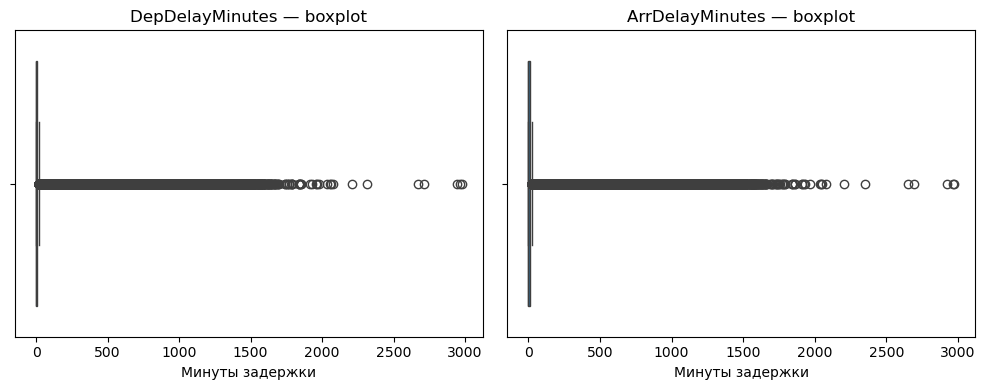

In [46]:
# Boxplot для анализа выбросов в задержках
# Преобразуем необходимые столбцы в pandas без ограничения объёма
dep_box_pd = df_dep.select("DepDelayMinutes").toPandas()
arr_box_pd = df_arr.select("ArrDelayMinutes").toPandas()

plt.figure(figsize=(10,4))

# DepDelayMinutes
plt.subplot(1,2,1)
sns.boxplot(x=dep_box_pd["DepDelayMinutes"])
plt.title("DepDelayMinutes — boxplot")
plt.xlabel("Минуты задержки")

# ArrDelayMinutes
plt.subplot(1,2,2)
sns.boxplot(x=arr_box_pd["ArrDelayMinutes"])
plt.title("ArrDelayMinutes — boxplot")
plt.xlabel("Минуты задержки")

plt.tight_layout()
plt.show()


Boxplot наглядно демонстрирует сильную скошенность распределений вправо. Основная масса значений сосредоточена вблизи нуля, однако верхние усы и многочисленные выбросы уходят на сотни и тысячи минут. Это подтверждает, что экстремальные задержки являются редкими, но существенно влияют на средние значения и визуальное восприятие данных.

Далее рассмотрим полные распределения задержек без каких-либо ограничений по диапазону значений.
Этот шаг позволяет увидеть, насколько длинный хвост распределений «растягивает» шкалу.

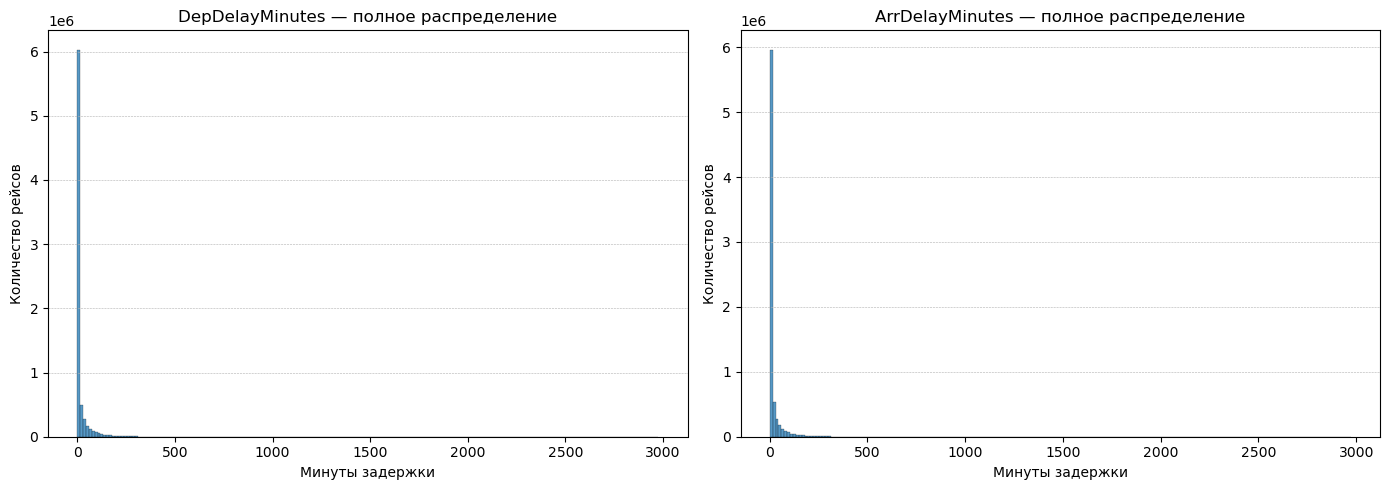

In [47]:
# Полные гистограммы задержек без ограничения диапазона

plt.figure(figsize=(14,5))

# Гистограмма задержек вылета (DepDelayMinutes)
plt.subplot(1,2,1)
sns.histplot(
    dep_box_pd["DepDelayMinutes"], 
    bins=200                                            # Большое число бинов для детального отображения хвоста
)
plt.title("DepDelayMinutes — полное распределение")
plt.xlabel("Минуты задержки")
plt.ylabel("Количество рейсов")
plt.grid(axis="y", linestyle="--", linewidth=0.4)       # Сетка по оси Y для удобства чтения частот

# Гистограмма задержек прибытия (ArrDelayMinutes)
plt.subplot(1,2,2)                                      # Второй подграфик
sns.histplot(
    arr_box_pd["ArrDelayMinutes"], 
    bins=200
)
plt.title("ArrDelayMinutes — полное распределение")
plt.xlabel("Минуты задержки")
plt.ylabel("Количество рейсов")
plt.grid(axis="y", linestyle="--", linewidth=0.4)

plt.tight_layout()

plt.show()

С учётом того, что 75% задержек не превышают 8–9 минут, имеет смысл отдельно проанализировать диапазон до 30 минут. Это позволяет изучить поведение подавляющего большинства рейсов без влияния экстремальных значений.

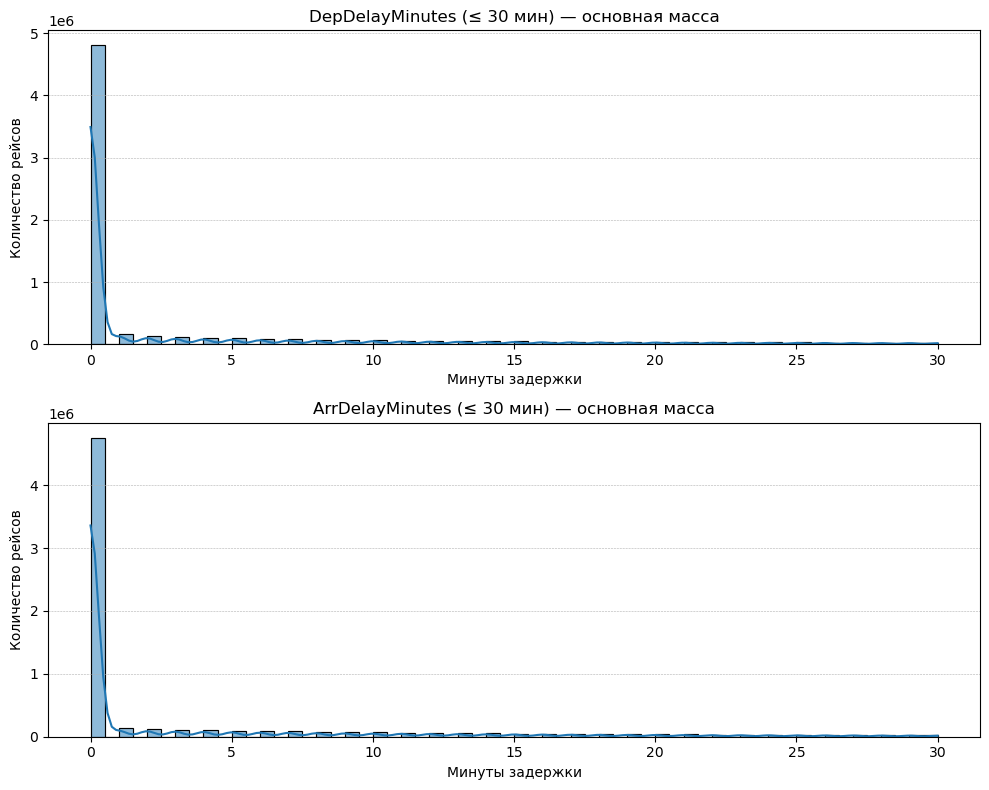

In [48]:
# Гистограммы для основной массы задержек (≤ 30 минут)

cap = 30

# Фильтрация данных: оставляем только записи с задержкой вылета ≤ 30 минут
# Убираем экстремальные выбросы для более информативного отображения основной массы рейсов
dep_pd_60 = dep_box_pd[dep_box_pd["DepDelayMinutes"] <= cap]

# Аналогичная фильтрация для задержек прибытия
arr_pd_60 = arr_box_pd[arr_box_pd["ArrDelayMinutes"] <= cap]

# Создание фигуры с двумя подграфиками, расположенными вертикально (2 строки, 1 столбец)
plt.figure(figsize=(10,8))

# Верхний график: распределение задержек вылета в диапазоне ≤ 30 минут
plt.subplot(2,1,1)                                      # Первый подграфик (верхний)
sns.histplot(
    dep_pd_60["DepDelayMinutes"], 
    bins=60,                                                # Количество интервалов для детализации
    kde=True                                                # Добавление кривой плотности
)
plt.title("DepDelayMinutes (≤ 30 мин) — основная масса")
plt.xlabel("Минуты задержки")
plt.ylabel("Количество рейсов")
plt.grid(axis="y", linestyle="--", linewidth=0.4)       # Сетка по оси Y для удобства чтения частот

# Нижний график: распределение задержек прибытия в диапазоне ≤ 30 минут
plt.subplot(2,1,2)                                      # Второй подграфик (нижний)
sns.histplot(
    arr_pd_60["ArrDelayMinutes"], 
    bins=60, 
    kde=True
)
plt.title("ArrDelayMinutes (≤ 30 мин) — основная масса")
plt.xlabel("Минуты задержки")
plt.ylabel("Количество рейсов")
plt.grid(axis="y", linestyle="--", linewidth=0.4)

plt.tight_layout()

plt.show()

При ограничении диапазона до 30 минут становится видно, что подавляющее большинство рейсов (более 70–75 %) либо не имеют задержки вовсе, либо задерживаются на незначительное время (0–5 минут). Распределения в этом диапазоне имеют резкий пик вблизи нуля и быстро убывающую плотность, что указывает на преобладание кратковременных задержек. При этом распределения задержек вылета и прилёта имеют схожую форму, однако задержки прибытия демонстрируют немного более «растянутый» хвост, что может быть связано с накоплением задержек в течение полёта.

## Анализ признака AirTime

`AirTime` — количественный признак, показывающий фактическое время в воздухе (в минутах).

Проверим, есть ли пропуски в этом столбце

In [49]:
# Проверка пропусков в AirTime
total = df.count()
airtime_nulls = df.filter(col("AirTime").isNull()).count()

print(f"Всего записей: {total}")
print(f"AirTime NULL: {airtime_nulls} ({airtime_nulls / total:.4%})")

Всего записей: 7633081
AirTime NULL: 142970 (1.8730%)


В столбце присутствует незначительное число пропусков, которые могут быть связаны с отменёнными/перенаправленными рейсами.

Пропуски не заполняются искусственно, так как это исказило бы распределение времени полёта. Далее продолжим анализ на подмножестве без пропусков

In [50]:
# Подмножество без пропусков для дальнейшего анализа
df_air = df.filter(col("AirTime").isNotNull())

Определим ключевые статистики признака

In [51]:
df_air.select("AirTime").summary(
    "count", "mean", "stddev", "min", "25%", "50%", "75%", "max"
).show(truncate=False)

+-------+------------------+
|summary|AirTime           |
+-------+------------------+
|count  |7490111           |
|mean   |109.67541575819104|
|stddev |69.92415112622807 |
|min    |4.0               |
|25%    |59.0              |
|50%    |91.0              |
|75%    |139.0             |
|max    |1557.0            |
+-------+------------------+



- медиана составляет 91 минуту — типичный рейс длится около полутора часов;
- 50% наблюдений лежат в диапазоне от 59 до 139 минут;
- среднее значение (~110 минут) заметно выше медианы, что указывает на правостороннюю асимметрию;
- максимальное значение превышает 1500 минут, что свидетельствует о наличии редких, но крайне длинных рейсов.

Построим диаграмму «ящик с усами», чтобы наглядно оценить положение основной массы данных и масштаб выбросов.

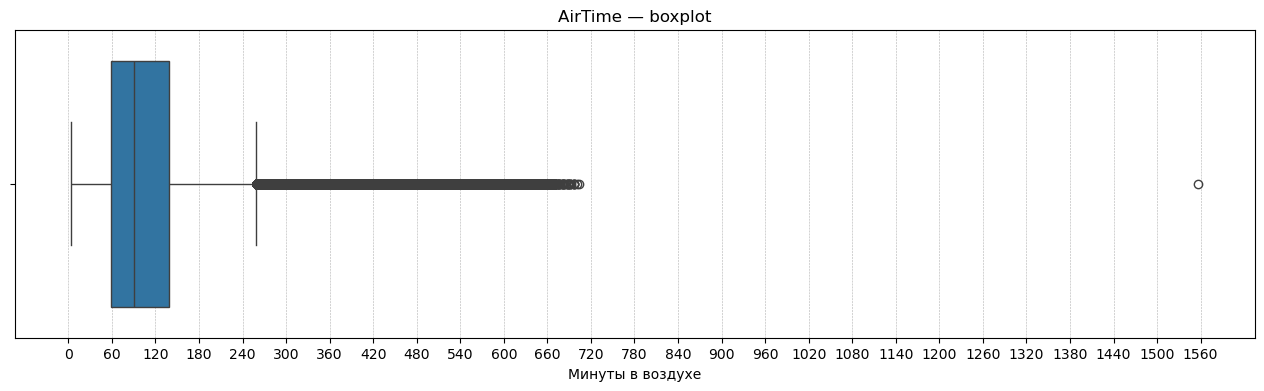

In [52]:
air_box_pd = df_air.select("AirTime").toPandas()

plt.figure(figsize=(16, 4))
sns.boxplot(x=air_box_pd["AirTime"])

# Определяем границы данных для оси X
x_min = int(air_box_pd["AirTime"].min())
x_max = int(air_box_pd["AirTime"].max())

# Создаем список меток от x_min до x_max с шагом 60
ticks = np.arange(0, x_max + 20, 60) 
plt.xticks(ticks)

plt.title("AirTime — boxplot")
plt.xlabel("Минуты в воздухе")
plt.grid(axis="x", linestyle="--", linewidth=0.4)
plt.show()

Диаграмма «ящик с усами» показывает, что основная масса времени полёта сосредоточена в интервале 60–140 минут. Медиана ≈91 мин, усы простираются примерно до 250–300 минут. Выбросы начинаются после ~250 минут и уходят до 1557 минут — это очень длинные трансатлантические и трансконтинентальные рейсы. Один экстремальный выброс на уровне ~1560 минут, возможно, аномалия или ошибка данных.

Посмотрим запись с самым большим значением времени полета:

In [53]:
df_air.orderBy(col("AirTime").desc()).limit(1).show(truncate=False)

+----------+------------------------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+
|FlightDate|Airline                 |Origin|Dest|Cancelled|Diverted|DepDelayMinutes|ArrDelayMinutes|AirTime|Distance|Year|Month|DayOfWeek|DepDel15|ArrDel15|
+----------+------------------------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+
|2019-03-27|ExpressJet Airlines Inc.|JAX   |EWR |false    |false   |0.0            |1439.0         |1557.0 |820.0   |2019|3    |3        |false   |true    |
+----------+------------------------+------+----+---------+--------+---------------+---------------+-------+--------+----+-----+---------+--------+--------+



Это событие является единичной аномалией. Удалим эту строку из основного датафрейма.

In [54]:
df = df.filter(~((col("AirTime") == 1557.0) & (col("FlightDate") == "2019-03-27")))

Обновим подмножество без пропусков и пересчитаем статистику.

In [55]:
df_air = df.filter(col("AirTime").isNotNull())

df_air.select("AirTime").summary(
    "count", "mean", "stddev", "min", "25%", "50%", "75%", "max"
).show(truncate=False)

+-------+------------------+
|summary|AirTime           |
+-------+------------------+
|count  |7490110           |
|mean   |109.67522252677198|
|stddev |69.9221559653646  |
|min    |4.0               |
|25%    |59.0              |
|50%    |91.0              |
|75%    |139.0             |
|max    |703.0             |
+-------+------------------+



Рассмотрим распределение значений без ограничения диапазона.

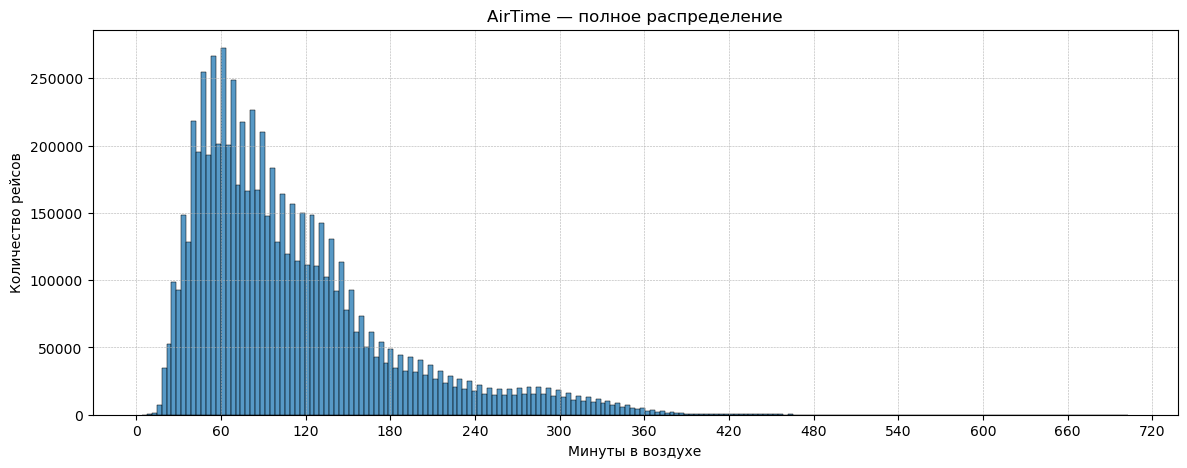

In [56]:
# Обновление pandas-подвыборки для построения гистограммы распределения времени в воздухе
air_box_pd = df_air.select("AirTime").toPandas()

# Создание фигуры для отображения полного распределения времени полёта
plt.figure(figsize=(14, 5))

# Построение гистограммы распределения AirTim
sns.histplot(air_box_pd["AirTime"], bins=200)

# Настройка меток оси X с шагом 60 минут для удобства чтения значений
x_ticks = np.arange(0, air_box_pd["AirTime"].max() + 20, 60)
plt.xticks(x_ticks)

# Добавление сетки по обеим осям для лучшей читаемости значений и частот
plt.grid(visible=True, which='major', axis='both', linestyle='--', linewidth=0.4)

# Установка заголовка и подписей осей
plt.title("AirTime — полное распределение")
plt.xlabel("Минуты в воздухе")
plt.ylabel("Количество рейсов")

# Отображение графика
plt.show()

Из-за наличия экстремально длинных рейсов шкала растягивается, и форма распределения основной массы становится плохо различимой. Ограничим диапазон для более детального анализа формы распределения.

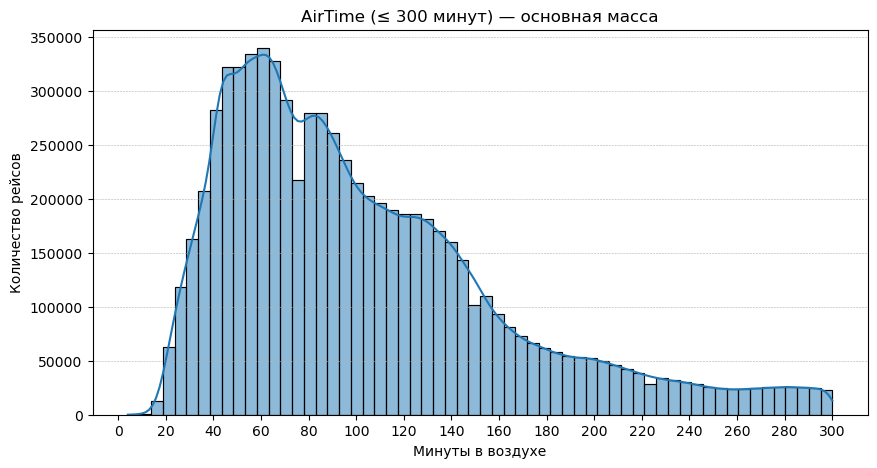

In [57]:
# Гистограмма для основной массы AirTime (<= 300 минут)
cap = 300
air_pd_cap = air_box_pd[air_box_pd["AirTime"] <= cap]

plt.figure(figsize=(10,5))
sns.histplot(air_pd_cap["AirTime"], bins=60, kde=True)
plt.title("AirTime (≤ 300 минут) — основная масса")
plt.xlabel("Минуты в воздухе")
plt.ylabel("Количество рейсов")
plt.grid(axis="y", linestyle="--", linewidth=0.4)


# Настройка подписей к оси X с шагом 20 минут
plt.xticks(range(0, cap + 1, 20))

plt.show()

Распределение времени в воздухе в основной массе имеет выраженный правосторонний характер с пиком около 40–70 минут и постепенным спадом. Плотность быстро падает после 200 минут, что соответствует типичным рейсам в США. Длинный правый хвост (за пределами 300 мин) формируется трансокеаническими и очень дальними внутренними рейсами и составляет малую долю наблюдений.

## Анализ признака Distance

Distance — количественный признак, отражающий расстояние перелёта (в милях).

Проверим, есть ли пропуски в Distance и подготовим подвыборкe для дальнейшего анализа.

In [58]:
# Проверка пропусков в Distance
total = df.count()
distance_nulls = df.filter(col("Distance").isNull()).count()

print(f"Всего записей: {total}")
print(f"Distance NULL: {distance_nulls} ({distance_nulls/total:.4%})")

# Подмножества: записи, где Distance определено; и где одновременно есть AirTime и Distance
df_dist_air = df.filter(col("AirTime").isNotNull())  # для совместного анализа


Всего записей: 7632826
Distance NULL: 0 (0.0000%)


Пропуски в столбце Distance отсутствуют

Определим ключевые статистики признака

In [59]:
df.select("Distance").summary(
    "count", "mean", "stddev", "min", "25%", "50%", "75%", "max"
).show(truncate=False)

+-------+-----------------+
|summary|Distance         |
+-------+-----------------+
|count  |7632826          |
|mean   |782.2244751812763|
|stddev |588.0206725437629|
|min    |31.0             |
|25%    |354.0            |
|50%    |621.0            |
|75%    |1014.0           |
|max    |5095.0           |
+-------+-----------------+



- медианное расстояние рейса составляет 621 милю, что соответствует коротким и средним внутренним перелётам;
- 50% всех рейсов лежат в диапазоне 354–1014 миль;
- среднее значение (~782 мили) выше медианы — распределение правосторонне асимметрично;
- стандартное отклонение велико, что указывает на существенную вариативность маршрутов;
- максимальное значение 5095 миль

Построим диаграмму «ящик с усами», чтобы оценить распределение основной массы данных и наличие выбросов.

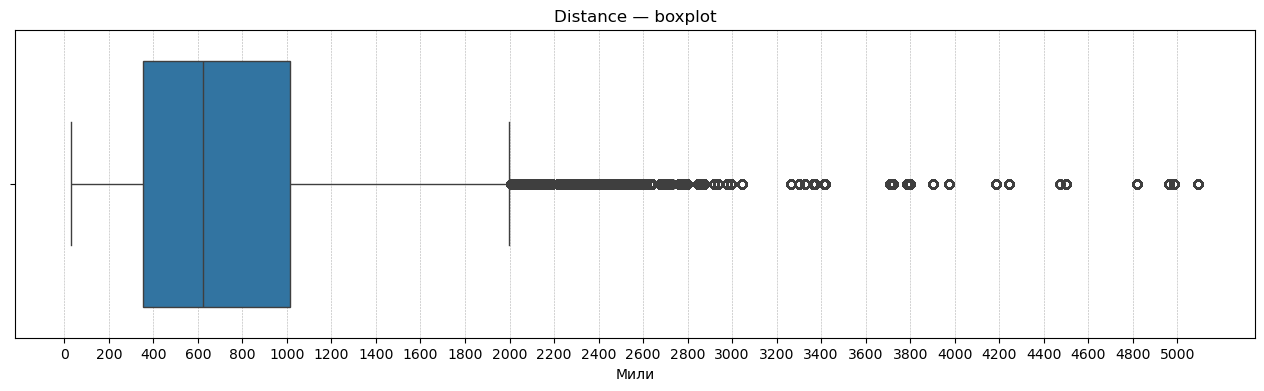

In [60]:
# Boxplot для Distance
# Переводим в pandas
dist_box_pd = df.select("Distance").toPandas()

plt.figure(figsize=(16,4))
sns.boxplot(x=dist_box_pd["Distance"])
plt.title("Distance — boxplot")
plt.xlabel("Мили")
# наглядные метки по оси X с шагом 200 миль
x_max = int(dist_box_pd["Distance"].max())
plt.xticks(np.arange(0, x_max + 1, 200))
plt.grid(axis="x", linestyle="--", linewidth=0.4)
plt.show()


Диаграмма показывает, что:
- основная масса расстояний сосредоточена от 350 до 1000 миль;
- медиана (~620 миль) смещена к нижней границе ящика;
- «усы» простираются примерно до 2000 миль;
- значения свыше ~2000 миль формируют длинный правый хвост и отображаются как выбросы;

Рассмотрим распределение расстояний по всему диапазону значений.

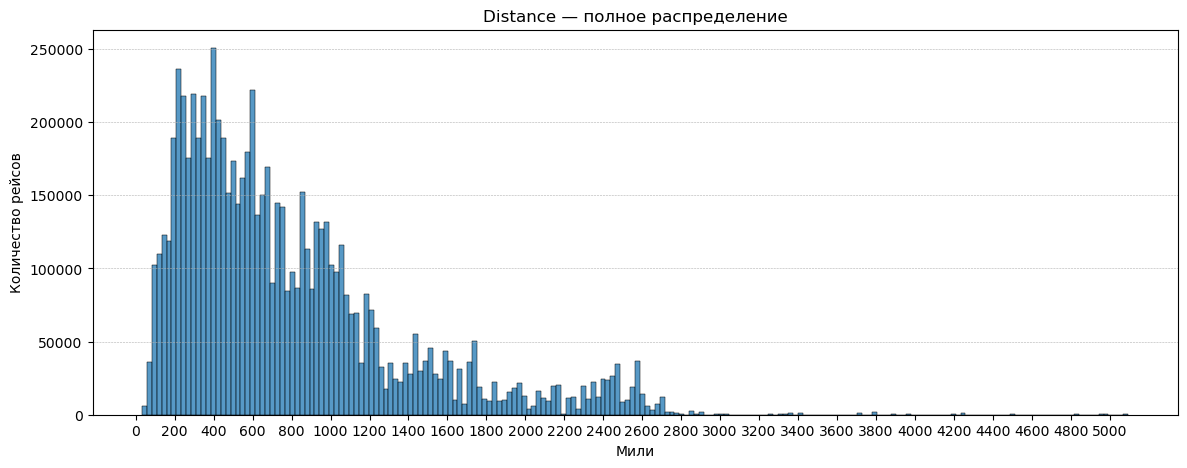

In [61]:
# Полное распределение Distance
plt.figure(figsize=(14,5))
sns.histplot(dist_box_pd["Distance"], bins=200)
plt.title("Distance — полное распределение")
plt.xlabel("Мили")
plt.ylabel("Количество рейсов")
# настройки оси X (шаг 200 миль)
plt.xticks(np.arange(0, dist_box_pd["Distance"].max() + 1, 200))
plt.grid(axis="y", linestyle="--", linewidth=0.4)
plt.show()


Для детального анализа типичных перелётов целесообразно исключить экстремально дальние рейсы (> 2800 миль), которые составляют малую долю и вероятнее всего являются аномалиями.

Удалим строки с Distance > 2800 миль из основного датафрейма.

In [62]:
df_before = df.count()

df = df.filter(col("Distance") <= 2800)

df_after = df.count()

print(f"До удаления: {df_before:,} строк")
print(f"После удаления рейсов > 2800 миль: {df_after:,} строк")
print(f"Удалено: {df_before - df_after:,} строк ({(df_before - df_after)/df_before:.4%})")

До удаления: 7,632,826 строк
После удаления рейсов > 2800 миль: 7,613,679 строк
Удалено: 19,147 строк (0.2509%)


In [63]:
# Обновляем подмножества после фильтрации
df_dist_air = df.filter(col("AirTime").isNotNull())
df_air = df.filter(col("AirTime").isNotNull())

print(f"Обновлено df_dist_air: {df_dist_air.count():,} строк")
print(f"Обновлено df_air: {df_air.count():,} строк")

Обновлено df_dist_air: 7,471,133 строк
Обновлено df_air: 7,471,133 строк


In [64]:
dist_box_pd = df.select("Distance").toPandas()

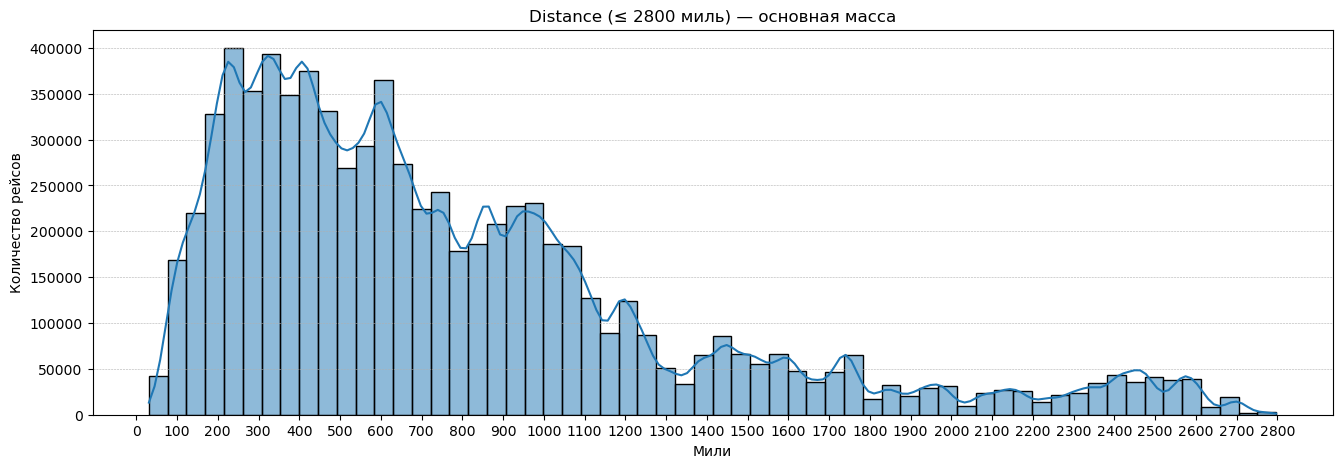

In [65]:
# Гистограмма для основной массы (<= 2800 миль)
cap = 2800
dist_cap_pd = dist_box_pd[dist_box_pd["Distance"] <= cap]

plt.figure(figsize=(16,5))
sns.histplot(dist_cap_pd["Distance"], bins=60, kde=True)
plt.title(f"Distance (≤ {cap} миль) — основная масса")
plt.xlabel("Мили")
plt.ylabel("Количество рейсов")
plt.xticks(range(0, cap + 1, 100))
plt.grid(axis="y", linestyle="--", linewidth=0.4)
plt.show()


Распределение расстояний в основной массе имеет выраженную правостороннюю асимметрию.
Основной пик приходится на диапазон 200–500 миль, что соответствует коротким региональным рейсам. Заметны локальные подъёмы плотности в районе 600 и 900–1000 миль, отражающие популярные средние маршруты. После ~1300 миль частота рейсов быстро снижается. Дальние рейсы (>2000 миль) составляют малую долю наблюдений и формируют длинный хвост распределения.

## Анализ крейсерской скорости

Расстояние перелёта (Distance) и фактическое время в воздухе (AirTime) физически связаны между собой. На этом этапе проверим силу и характер этой зависимости.

Сначала оценим линейную зависимость между признаками на всей выборке с использованием корреляции Пирсона.

In [66]:
# Корреляция Distance и AirTime на уровне Spark

corr_val = df_dist_air.select(
    corr("Distance", "AirTime")
).collect()[0][0]

print(f"Pearson correlation (Distance, AirTime): {corr_val:.4f}")


Pearson correlation (Distance, AirTime): 0.9828


Корреляция Пирсона близка к 1, что указывает на сильную положительную линейную связь: с ростом расстояния перелёта увеличивается и время в воздухе. Это ожидаемый и физически обоснованный результат.

Для визуального анализа и расчёта скорости возьмём случайную подвыборку 10 % данных.

In [67]:
# Создание случайной представительной подвыборки для визуализации и расчёта скорости
# fraction=0.1 — отбираем 10 % записей (достаточно для надёжных статистик и графиков при большом объёме данных)
# seed=42 — фиксируем начальное значение генератора случайных чисел для воспроизводимости результатов
# withReplacement=False — выборка без возвращения (каждая строка может попасть в подвыборку не более одного раза)
sample_pd = (
    df_dist_air
    .sample(withReplacement=False, fraction=0.1, seed=42)   # Случайная стратифицированная выборка
    .select("Distance", "AirTime")
    .toPandas()
)

# Вывод размера полученной подвыборки
print(f"Размер подвыборки: {len(sample_pd):,} строк")

Размер подвыборки: 747,579 строк


Рассчитаем приближённую крейсерскую скорость (в километрах в час)

In [68]:
# Расчёт приближённой крейсерской скорости в километрах в час
# Скорость вычисляется только для физически корректных рейсов 
# (AirTime > 0 и Distance > 0), чтобы избежать деления на ноль и нереалистичных значений

sample_pd_speed = sample_pd[
    (sample_pd["AirTime"] > 0) & (sample_pd["Distance"] > 0)
].copy()  # Создаём копию отфильтрованного подмножества для безопасных преобразований

# Формула: скорость = расстояние (мили) × 1.60934 (коэффициент перевода в км) / время (часы)
# AirTime делим на 60, чтобы перевести минуты в часы
sample_pd_speed["speed_kmh"] = (
    sample_pd_speed["Distance"] * 1.60934 / (sample_pd_speed["AirTime"] / 60.0)
)

# Вывод описательных статистик рассчитанной скорости
print("Крейсерская скорость (км/ч) — описательные статистики (по sample):")
print(sample_pd_speed["speed_kmh"].describe())

Крейсерская скорость (км/ч) — описательные статистики (по sample):
count    747579.000000
mean        643.588745
std         119.655510
min          41.005100
25%         570.965881
50%         654.931396
75%         725.666016
max        1281.812744
Name: speed_kmh, dtype: float64


Медианная скорость составляет  примерно 655 км/ч, среднее значение (644 км/ч) близко к медиане. Межквартильный диапазон примерно 571–726 км/ч. Минимальные и максимальные значения могут быть связаны с аномальными данными.

Оценим наличие выбросов и распределение значений крейсерской скорости с помощью диаграммы «ящик с усами».

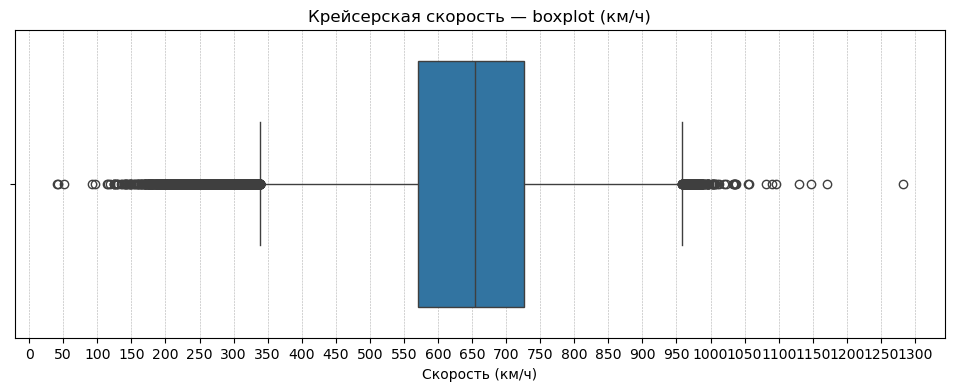

In [69]:
# Boxplot крейсерской скорости (только км/ч)
plt.figure(figsize=(12, 4))
sns.boxplot(x=sample_pd_speed["speed_kmh"])
plt.title("Крейсерская скорость — boxplot (км/ч)")
plt.xlabel("Скорость (км/ч)")
plt.grid(axis="x", linestyle="--", linewidth=0.4)

# Удобные деления оси X
x_max = int(sample_pd_speed["speed_kmh"].max())
plt.xticks(np.arange(0, x_max + 50, 50))
plt.show()

Диаграмма "ящик с усами" показывает, что основная масса значений крейсерской скорости сосредоточена примерно в диапазоне 570–730 км/ч, при медиане около 655 км/ч.
При этом наблюдаются:
- крайне низкие значения (< 300 км/ч)
- экстремально высокие значения (> 1000 км/ч)
Для анализа типичных крейсерских режимов полёта целесообразно исключить такие выбросы.

Для дальнейшего анализа оставим скорости в диапазоне 350–1000 км/ч, что соответствует реалистичным значениям крейсерской скорости гражданских воздушных судов.

In [70]:
# Фильтрация реалистичных скоростей (только км/ч)
lower_kmh = 350
upper_kmh = 1000

sample_pd_speed_clean = sample_pd_speed[
    (sample_pd_speed["speed_kmh"] >= lower_kmh) &
    (sample_pd_speed["speed_kmh"] <= upper_kmh)
].copy()

print(f"Исходный размер подвыборки: {len(sample_pd_speed):,}")
print(f"После фильтрации: {len(sample_pd_speed_clean):,}")
print(f"Удалено аномалий: {len(sample_pd_speed) - len(sample_pd_speed_clean):,} "
      f"({(len(sample_pd_speed) - len(sample_pd_speed_clean)) / len(sample_pd_speed):.4%})")

# Статистика после очистки
print("\nСтатистика после очистки (км/ч):")
print(sample_pd_speed_clean["speed_kmh"].describe())

Исходный размер подвыборки: 747,579
После фильтрации: 736,054
Удалено аномалий: 11,525 (1.5416%)

Статистика после очистки (км/ч):
count    736054.000000
mean        648.858582
std         112.693100
min         350.031433
25%         575.718567
50%         657.201843
75%         726.812683
max         997.790710
Name: speed_kmh, dtype: float64


Оценим распределение скоростей после очистки.

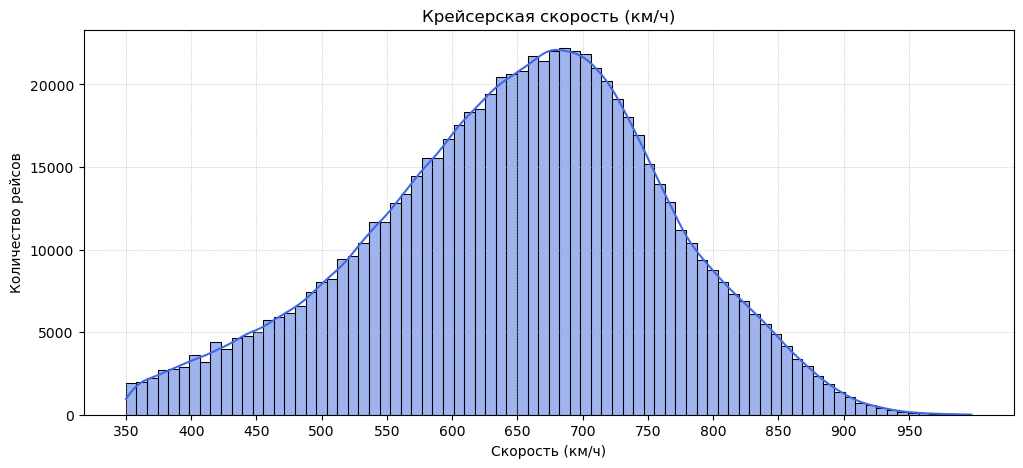

In [71]:
# Построение гистограммы распределения крейсерской скорости после исключения аномалий

plt.figure(figsize=(12, 5))

# Строим гистограмму с ядерной оценкой плотности (kde=True) для наглядного отображения формы
sns.histplot(
    sample_pd_speed_clean["speed_kmh"], 
    bins=80, 
    kde=True, 
    color='royalblue'
)

# Настраиваем шаг меток по оси X (каждые 50 км/ч) в диапазоне реалистичных скоростей
ticks = np.arange(350, 1000, 50)
plt.xticks(ticks)

# Улучшаем сетку: добавляем линии по обеим осям с прозрачностью для лучшей читаемости
plt.grid(axis="both", linestyle="--", linewidth=0.4, alpha=0.7)

# Установка заголовка и подписей осейрейсов
plt.title("Крейсерская скорость (км/ч)")
plt.xlabel("Скорость (км/ч)")
plt.ylabel("Количество рейсов")

# Отображение графика
plt.show()

Гистограмма распределения крейсерской скорости показываетодин выраженный пик в диапазоне 640-730 км/ч, соответствующий крейсерскому режиму большинства рейсов. Заметно плавное убывание плотности к краям распределения без резких разрывов.
Небольшой правый хвост распределения обусловлен редкими рейсами с высокой путевой скоростью. Левый хвост формируется короткими рейсами, где значительную долю времени занимает взлёт и снижение.

## Анализ столбца DayOfWeek

DayOfWeek — категориальный признак, обозначающий день недели (1 — понедельник, 7 — воскресенье).

Проверим наличие пропусков в столбце

In [72]:
count_nulls(data=df, column_name="DayOfWeek")

Число колонок с NULL: 0 (0.00%)


Пропусков нет.

Посмотрим распределение количества рейсов по дням недели.

In [73]:
# Подсчёт рейсов по дням недели + доля от общего числа
day_counts = (
    df
    .groupBy("DayOfWeek")
    .count()
    .withColumn("share", col("count") / df.count())
    .orderBy("DayOfWeek")
)

day_counts.show()

+---------+-------+-------------------+
|DayOfWeek|  count|              share|
+---------+-------+-------------------+
|        1|1131971|0.14867595547435083|
|        2|1100736| 0.1445734709855774|
|        3|1098014| 0.1442159565697477|
|        4|1125118|0.14777586499246947|
|        5|1135748|0.14917203627838788|
|        6| 937035|0.12307256452498194|
|        7|1085057|0.14251415117448477|
+---------+-------+-------------------+



В рабочие дни (1-5) нагрузка распределена почти равномерно с долей около 14.5–14.9% на каждый день. Наблюдается значительный спад активности в субботу (доля падает до 12.3%). К воскресенью (7) объем перевозок снова растет (до 14.2%)

Для наглядной оценки распределения построим столбчатую диаграмму.

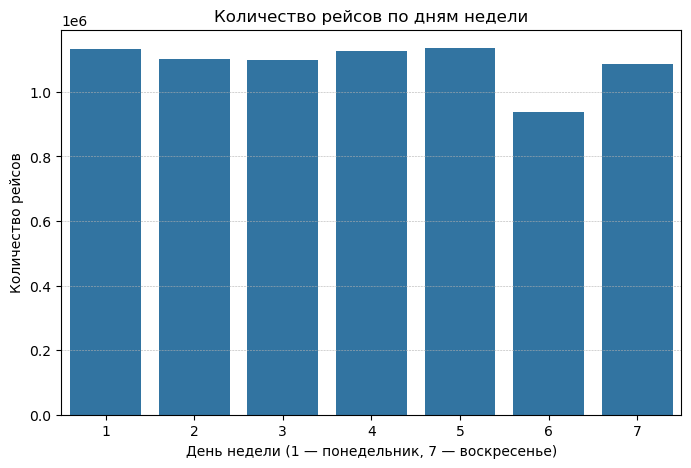

In [74]:
# Визуализация — барплот топ-дней недели
day_pd = day_counts.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x="DayOfWeek", y="count", data=day_pd)
plt.title("Количество рейсов по дням недели")
plt.xlabel("День недели (1 — понедельник, 7 — воскресенье)")
plt.ylabel("Количество рейсов")
plt.grid(axis="y", linestyle="--", linewidth=0.4)
plt.show()

Диаграмма подтверждает, что пик авиаперевозок приходится на первый и последний будние дни, а выходные (суббота и воскресенье) демонстрируют небольшое снижение объёма рейсов.

## Анализ столбца `Month`

Month — категориальный признак, обозначающий месяц вылета (1 — январь, 12 — декабрь).

Проверим наличие пропусков в столбце

In [75]:
count_nulls(data=df, column_name="Month")

Число колонок с NULL: 0 (0.00%)


Пропусков нет.

Посмотрим распределение количества рейсов по месяцам.

In [76]:
# Подсчёт рейсов по месяцам + доля от общего числа
month_counts = (
    df
    .groupBy("Month")
    .count()
    .withColumn("share", col("count") / df.count())
    .orderBy("Month")
)

month_counts.show()

+-----+------+-------------------+
|Month| count|              share|
+-----+------+-------------------+
|    1|598755|0.07864200736595278|
|    2|553335|0.07267642883289406|
|    3|649180|0.08526495535207092|
|    4|626918|0.08234100754707416|
|    5|654046|0.08590406819094948|
|    6|660161|0.08670722787235974|
|    7|676080|0.08879806989498769|
|    8|675110|0.08867066762336578|
|    9|610129|0.08013589750763067|
|   10|650209| 0.0854001068340286|
|   11|613171|0.08053544153884082|
|   12|646585| 0.0849241214398453|
+-----+------+-------------------+



Количество рейсов по месяцам распределено неравномерно: пик приходится на летние месяцы (июнь–август — 8.7–8.9 % каждый), минимум — на февраль (≈7.3 %). Это отражает сезонный характер авиаперевозок: лето — высокий туристический спрос, зима — спад.

Для наглядной оценки построим столбчатую диаграмму.

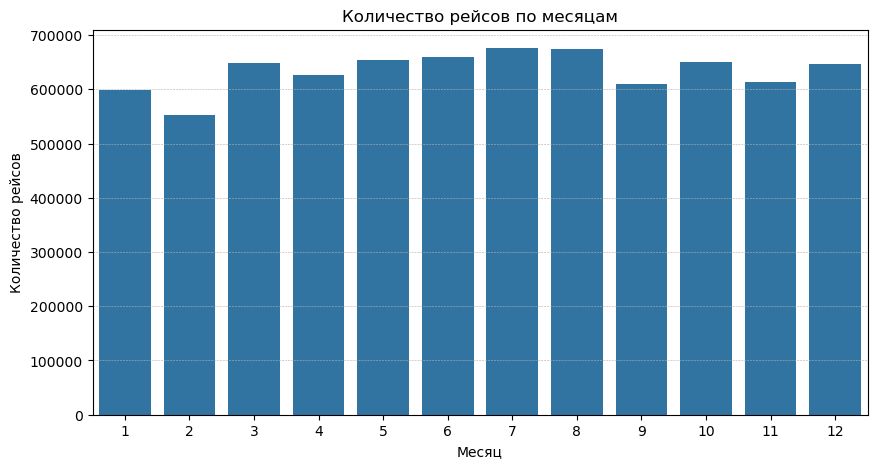

In [77]:
# Визуализация — барплот по месяцам
month_pd = month_counts.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x="Month", y="count", data=month_pd)
plt.title("Количество рейсов по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество рейсов")
plt.grid(axis="y", linestyle="--", linewidth=0.4)
plt.show()

Диаграмма подтверждает летний пик (июнь–август) и зимний спад (январь–февраль). Весна и осень занимают промежуточное положение.

Полезно также посмотреть, как меняется средняя задержка вылета по месяцам — это покажет сезонный риск опозданий.

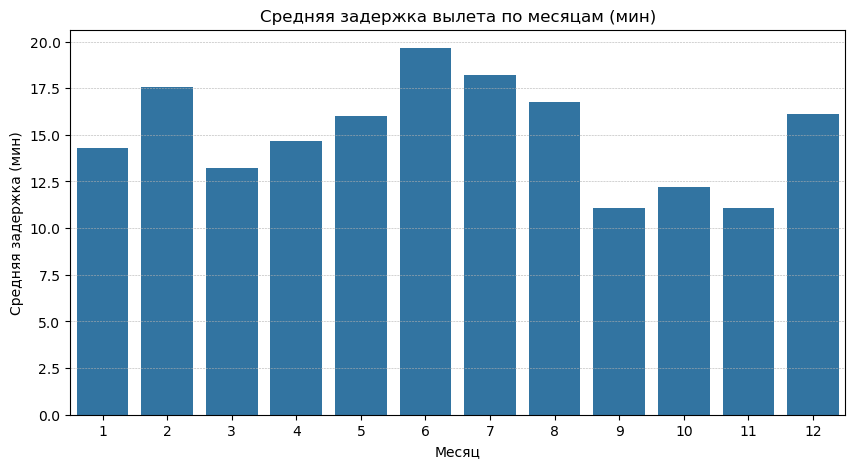

In [78]:
# Средняя задержка вылета по месяцам
delay_by_month = (
    df
    .groupBy("Month")
    .agg(mean("DepDelayMinutes").alias("avg_dep_delay"))
    .orderBy("Month")
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.barplot(x="Month", y="avg_dep_delay", data=delay_by_month)
plt.title("Средняя задержка вылета по месяцам (мин)")
plt.xlabel("Месяц")
plt.ylabel("Средняя задержка (мин)")
plt.grid(axis="y", linestyle="--", linewidth=0.4)
plt.show()

Средняя задержка вылета заметно выше в летние месяцы (июнь–август — 17–19.5 мин), в феврале (≈17.5 мин) и в декабре (≈16 мин), что коррелирует с пиковой загрузкой аэропортов и неблагоприятными погодными условиями зимой. Минимальные задержки наблюдаются в феврале и сентябре–ноябре (≈11–13 мин).

## Анализ столбца Year

Year — количественный признак, указывающий год выполнения рейса.

Проверим наличие пропусков.

In [79]:
count_nulls(data=df, column_name="Year")

Число колонок с NULL: 0 (0.00%)


Пропусков нет.

Посмотрим распределение записей по годам.

In [80]:
year_counts = (
    df
    .groupBy("Year")
    .count()
    .orderBy("Year")
)

year_counts.show()

+----+-------+
|Year|  count|
+----+-------+
|2019|7613679|
+----+-------+



Столбец Year содержит только одно уникальное значение — 2019. Он не несёт никакой вариативности и не влияет на анализ задержек, сезонности или других зависимостей.

Удалим этот столбец, чтобы упростить структуру данных и избежать включения бесполезного признака в будущие модели.

In [81]:
df = df.drop("Year")

## Расчет корреляции между количественными признаками

In [82]:
def compute_and_visualize_correlation_matrix(data: DataFrame, columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных колонок в PySpark DataFrame.

    Args:
        df (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Корреляционная матрица")
    plt.show()

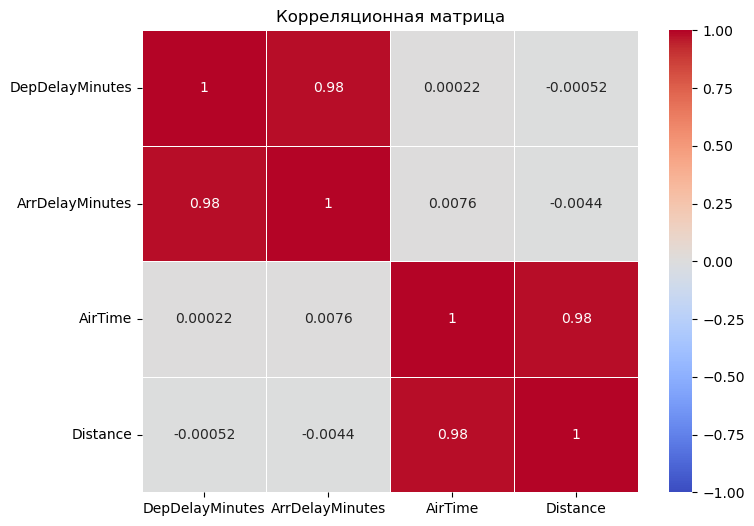

In [83]:
compute_and_visualize_correlation_matrix(
    data=df,
    columns=["DepDelayMinutes", "ArrDelayMinutes", "AirTime", "Distance"]
)

Между задержками вылета и прибытия наблюдается очень сильная положительная корреляция (0.98) — задержка на старте почти полностью передаётся на финиш.
Время в воздухе и расстояние также линейно связаны (0.98), что ожидаемо.
При этом задержки практически не зависят от длины маршрута и длительности полёта (коэффициенты близки к нулю: от –0.004 до +0.007).
Основные причины задержек лежат вне физических характеристик рейса — скорее всего, в операционных и погодных факторах.

In [84]:
df.limit(10).toPandas().style

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,DepDelayMinutes,ArrDelayMinutes,AirTime,Distance,Month,DayOfWeek,DepDel15,ArrDel15
0,2019-04-23,Envoy Air,LIT,ORD,False,False,1.000000,0.000000,83.000000,552.000000,4,2,False,False
1,2019-04-03,Envoy Air,ILM,LGA,False,False,0.000000,0.000000,75.000000,500.000000,4,3,False,False
2,2019-04-06,Envoy Air,MEM,DFW,False,False,13.000000,24.000000,88.000000,431.000000,4,6,False,True
3,2019-04-20,Envoy Air,MIA,PIT,False,False,4.000000,0.000000,118.000000,1013.000000,4,6,False,False
4,2019-04-22,Envoy Air,LGA,RIC,False,False,0.000000,37.000000,65.000000,292.000000,4,1,False,True
5,2019-04-19,Envoy Air,ORD,OMA,False,False,0.000000,0.000000,61.000000,416.000000,4,5,False,False
6,2019-04-19,Envoy Air,DFW,BIL,False,False,0.000000,0.000000,157.000000,1081.000000,4,5,False,False
7,2019-04-22,Envoy Air,DFW,BIL,False,False,0.000000,0.000000,136.000000,1081.000000,4,1,False,False
8,2019-04-10,Envoy Air,ORF,LGA,False,False,0.000000,22.000000,58.000000,296.000000,4,3,False,True
9,2019-04-13,Envoy Air,ORD,ABQ,False,False,0.000000,0.000000,153.000000,1118.000000,4,6,False,False


Посмотрим, сколько объектов осталось после преобразований датасета.

In [85]:
df.count()

7613679

In [86]:
df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- DepDelayMinutes: float (nullable = true)
 |-- ArrDelayMinutes: float (nullable = true)
 |-- AirTime: float (nullable = true)
 |-- Distance: float (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepDel15: boolean (nullable = true)
 |-- ArrDel15: boolean (nullable = true)



Сохраняем очищенную и обработанную таблицу на диск.

In [87]:
processed_table_name = "sobd_lab1_flight_processed"

In [88]:
df.writeTo(f"spark_catalog.{database_name}.{processed_table_name}") \
  .using("iceberg") \
  .createOrReplace()

Проверим, что таблица появилась в каталоге.

In [89]:
for table in spark.catalog.listTables(database_name):
    print(table.name)

sobd_lab1_table
sobd_lab1_flight_table
sobd_lab1_flight_processed


Останавливаем Spark-сессию.

In [90]:
spark.stop()